# Introduction to Data Science - Project Phase 3
---

In [116]:
import pandas as pd
import numpy as np

import re
import random

from sklearn.preprocessing import LabelEncoder
from scipy.stats import norm

import seaborn as sns
from seaborn import heatmap, diverging_palette, histplot, barplot, violinplot, boxplot, pointplot
import matplotlib.pyplot as plt

import geopandas as gpd
from shapely.geometry import Point, box
from scipy.ndimage import gaussian_filter

# Read Data

In [3]:
data = pd.read_csv('./data.csv')

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43362 entries, 0 to 43361
Data columns (total 25 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    43362 non-null  int64  
 1   price                 41674 non-null  float64
 2   beds                  38922 non-null  float64
 3   baths                 40695 non-null  float64
 4   garage                25052 non-null  float64
 5   stories               28833 non-null  float64
 6   house_type            43350 non-null  object 
 7   lot_sqft              30091 non-null  float64
 8   sqft                  36344 non-null  float64
 9   year_built            31806 non-null  float64
 10  address               43209 non-null  object 
 11  postal_code           43342 non-null  float64
 12  state                 43362 non-null  object 
 13  city                  43352 non-null  object 
 14  tags                  42892 non-null  object 
 15  is_new_construction

# Utils

In [5]:
def missing_report(data):
	nan_values = pd.DataFrame()
	nan_values['missing_count'] = data.isna().sum()
	nan_values['missing_percentage'] = nan_values['missing_count'] / data.shape[0] * 100
	nan_values = nan_values[nan_values['missing_count'] > 0]
	return nan_values.round(4)

## Parse Tags

In [6]:
def parse_tags(x):
	if(pd.isnull(x)):
		return set()
	pattern = r'[' + re.escape(''.join(['[', ']', '\'', ' '])) + r']'
	x = re.sub(pattern, '', x)
	tags = set(x.split(','))
	return tags

def feature_extraction(x, feature):
	tags = parse_tags(x['tags'])
	return feature in tags


def get_all_tags_dist(data):
	tag_counts = dict()

	for x in data['tags']:
		tags = parse_tags(x)
		for tag in tags:
			if(tag in tag_counts):
				tag_counts[tag] += 1
			else:
				tag_counts[tag] = 1
	return tag_counts

## Fill by K-Nearest Neighbour according to Latitude and Longitude 

In [7]:
def fill_by_knn_lat_lon(x: pd.Series, data: pd.DataFrame, feature = None, k = 1):
	if(not pd.isnull(x[feature])):
		return x[feature]
	dist = np.sqrt((data.lat - x.lat) ** 2 + (data.lon - x.lon) ** 2)
	data['dist'] = dist
	sorted_data = data.sort_values(by = ['dist'])
	while(True):
		filtered_data = sorted_data.iloc[:k]
		if(len(filtered_data[feature].mode()) > 0):
			break
		k += 1
	data = data.drop(columns=['dist'], axis=1)
	return filtered_data[feature].mode()[0]


## Fill by K-Nearest Neighbour according to Square Feets

In [8]:
def fill_by_knn_sqft(x: pd.Series, data: pd.DataFrame, feature = None, k = 1):
	if(not pd.isnull(x[feature])):
		return x[feature]
	
	dist = np.abs(data['sqft'] - x['sqft'])
	data['dist'] = dist
	sorted_data = data.sort_values(by = ['dist'])
	data = data.drop(columns=['dist'], axis=1)
	while(True):
		filtered_data = sorted_data.iloc[:k]
		m = filtered_data[feature].mean()
		if(pd.notnull(m)):
			return np.ceil(m)
		k += 1


## Fill by Averaging random sample according to the Distribution of a specific columns


In [9]:
def fill_by_dist(x, data, feature, by, k = 10):
    return np.ceil(data[data[by] == x[by]][feature].sample(n = k).mean())

# Preprocess

## Duplicated

In [10]:
data.duplicated().sum()

0

## Drop Unnecessary Features

Some features like address, ID and postal code is not proper for analyzing.

In [11]:
missing_report(data)

,missing_count,missing_percentage
price,1688,3.8928
beds,4440,10.2394
baths,2667,6.1505
garage,18310,42.2259
stories,14529,33.5063
house_type,12,0.0277
lot_sqft,13271,30.6051
sqft,7018,16.1847
year_built,11556,26.6501
address,153,0.3528


In [12]:
data = data.drop(columns=['id', 'postal_code', 'address'], axis=1)


## Drop Features with High Null Values

Some Features has many null values and there is heuristic in other features to help filling them. 

In [13]:
data = data.drop(columns=['lot_sqft'], axis=1)


## Tags

There is a column in the data called tags. It contains a list of house features. We used to fill null values and creating new features. 

In [14]:
dict(sorted(get_all_tags_dist(data).items(), key=lambda item: item[1], reverse=True))

{'garage_1_or_more': 28771,
 'garage_2_or_more': 20432,
 'central_air': 19063,
 'dishwasher': 17038,
 'two_or_more_stories': 16535,
 'community_outdoor_space': 16208,
 'single_story': 15063,
 'basement': 14503,
 'fireplace': 14133,
 'laundry_room': 12742,
 'forced_air': 12098,
 'washer_dryer': 10777,
 'hardwood_floors': 9625,
 'dining_room': 9323,
 'recreation_facilities': 9305,
 'view': 9185,
 'shopping': 8805,
 'big_lot': 8749,
 'family_room': 8620,
 'central_heat': 7305,
 'floor_plan': 6668,
 'rental_property': 6425,
 'new_construction': 6315,
 'pets_allowed': 5567,
 'community_swimming_pool': 4772,
 'modern_kitchen': 4728,
 'community_security_features': 4708,
 'farm': 4593,
 'lake': 4559,
 'views': 4528,
 'garage_3_or_more': 4465,
 'trails': 4062,
 'water_view': 4059,
 'open_floor_plan': 3742,
 'ranch': 3734,
 'ensuite': 3723,
 'fenced_yard': 3717,
 'den_or_office': 3539,
 'park': 3483,
 'waterfront': 3245,
 'updated_kitchen': 3175,
 'groundscare': 2972,
 'corner_lot': 2926,
 'hil

## Features

### price

Price is the target variable, so we drop the columns with null value in their price.

In [15]:
data = data[data['price'].notnull()]
data.shape[0]

41674

### latitude and longitude

we impute the latitude and longitude with mean of city, if the city was unknown we use county's mean and if that was null too, we use state's mean.

In [16]:
def fill_lat_lon_by_geo(x:pd.Series, data: pd.DataFrame):
	if(not pd.isnull(x.lat) and not pd.isnull(x.lon)):
		return [x.lat, x.lon]
	if(not pd.isnull(x['city'])):
		c = data[data['city'] == x['city']]
		lat = c.lat.dropna().mean()
		lon = c.lon.dropna().mean()
		if(not pd.isnull(lat) and not pd.isnull(lon)):
			return [lat, lon]
	if(not pd.isnull(x['county'])):
		c = data[data['county'] == x['county']]
		lat = c.lat.dropna().mean()
		lon = c.lon.dropna().mean()
		if(not pd.isnull(lat) and not pd.isnull(lon)):
			return [lat, lon]
	if(not pd.isnull(x['state'])):
		c = data[data['state'] == x['state']]
		lat = c.lat.dropna().mean()
		lon = c.lon.dropna().mean()
		if(not pd.isnull(lat) and not pd.isnull(lon)):
			return [lat, lon]

In [17]:
filled = data.apply(lambda x: fill_lat_lon_by_geo(x, data), axis=1)

In [18]:
lat = []
lon = []
for x in filled:
    lat.append(x[0])
    lon.append(x[1])
data.lat = lat
data.lon = lon

In [19]:
data.lat.isnull().sum()

0

## Status

In [20]:
data['status'].value_counts(dropna=False)

status
for_sale          34824
for_rent           6003
ready_to_build      847
Name: count, dtype: int64

## state

In [21]:
data['state'].isnull().sum()


0

## city

We use the mode of k nearest houses according to the distance calculated usng lat and lon to fill the missng values. We use $k = 1$. 

In [22]:
data['city'].isnull().sum()

10

In [23]:
data['city'] = data.apply(
    lambda x: fill_by_knn_lat_lon(x, data, 'city', 1),
    axis = 1
)

In [24]:
data['city'].isnull().sum()


0

### county

Imputation of this feature is same as city.

In [25]:
data['county'].isnull().sum()

101

In [26]:
data['county'] = data.apply(
    lambda x: fill_by_knn_lat_lon(x, data, 'county', 1),
    axis = 1
)

In [27]:
data['county'].isnull().sum()


0

## Farm

Determines whether a house has a farm or not.

In [28]:
def farm_feature(x: pd.Series):
    tags = parse_tags(x['tags'])
    if(x['house_type'] == 'farm' or 'farm' in tags):
        return 1
    return 0

In [29]:
data['farm'] = data.apply(farm_feature, axis=1)

In [30]:
data['farm'].value_counts()

farm
0    36959
1     4715
Name: count, dtype: int64

### Office

Determines whether the house can be used as office or not.

In [31]:
def office_feature(x):
    tags =  parse_tags(x['tags'])
    return 'den_or_office' in tags

In [32]:
data['office'] = data.apply(office_feature, axis=1)
data['office'].value_counts()

office
False    38139
True      3535
Name: count, dtype: int64

### house type

Determines house type.

In [33]:
data.house_type.value_counts(dropna=False)

house_type
single_family                  30515
condos                          2584
land                            2515
townhomes                       2133
mobile                          1368
apartment                       1093
multi_family                     899
farm                             261
duplex_triplex                   101
coop                              50
townhouse                         40
condo_townhome_rowhome_coop       37
condo_townhome                    31
other                             20
condo                             15
NaN                               12
Name: count, dtype: int64

1. Single-Family Homes:
- Reason: 'single_family' is already a clear and distinct category, so it makes sense to keep it as its own group.
2. Attached Homes:
- Reason: 'townhomes', 'townhouse', 'condo_townhome_rowhome_coop', and 'condo_townhome' are all types of attached or semi-attached housing, such as townhouses, row homes, and condominiums with common walls. Grouping these together makes sense as they represent a similar type of residential property.
3. Condos:
- Reason: 'condos' and 'condo' are both clearly referring to condominium units, so it makes sense to group them together.
4. Multi-Family Homes:
- Reason: 'multi_family' and 'duplex_triplex' both represent residential properties that house multiple families or units, so they can be logically grouped together.

In [34]:
data['house_type'] = data['house_type'].replace('single_family', 'Single-Family Homes')
data['house_type'] = data['house_type'].replace(['townhomes', 'townhouse', 'condo_townhome_rowhome_coop', 'condo_townhome'], 'Attached Homes')
data['house_type'] = data['house_type'].replace(['condos', 'condo'], 'Condos')
data['house_type'] = data['house_type'].replace(['multi_family', 'duplex_triplex'], 'Multi-Family Homes')
data['house_type'] = data['house_type'].replace([np.nan, 'duplex_triplex'], 'Multi-Family Homes')

In [35]:
data.house_type.value_counts(dropna=False)


house_type
Single-Family Homes    30515
Condos                  2599
land                    2515
Attached Homes          2241
mobile                  1368
apartment               1093
Multi-Family Homes      1012
farm                     261
coop                      50
other                     20
Name: count, dtype: int64

### sqft

We used the average of city's(or county's if city null and state's if county is also null) average sqft to fill missing values. 

In [36]:
def fill_sqft_by_mean_house_type_in_state(x, data):
	if(not pd.isnull(x['sqft'])):
		return x['sqft']

	c = data[(data['city'] == x['city'])]['sqft'].dropna().mean()
	if(not pd.isnull(c)):
		return c
	c = data[(data['county'] == x['county'])]['sqft'].dropna().mean()
	if(not pd.isnull(c)):
		return c
	c = data[(data['state'] == x['state'])]['sqft'].dropna().mean()
	if(not pd.isnull(c)):
		return c

In [37]:
data['sqft'] = data.apply(lambda x: fill_sqft_by_mean_house_type_in_state(x, data), axis=1)

### beds

We used the mean of k-nearest house according to the size of house in sqft to fill the missing values.

In [38]:
data.beds.isnull().sum()

2825

In [39]:
data['beds'] = data.apply(lambda x: fill_by_knn_sqft(x, data, 'beds', 25), axis=1) 

In [40]:
data.beds.isnull().sum()


0

### baths

Imputation of this feature is same as beds.

In [41]:
data['baths'].isnull().sum()


1031

In [42]:
data['baths'] = data.apply(lambda x: fill_by_knn_sqft(x, data, 'baths', 25), axis=1) 

In [43]:
data['baths'].isnull().sum()

0

### year built

we used average of 10 random sample in that state to fill the missing values.

In [44]:
data['year_built'].isnull().sum()

9972

In [45]:
data['year_built'] = data.apply(lambda x: fill_by_dist(x=x, data=data, by='state', feature='year_built'), axis=1)

In [46]:
data['year_built'].isnull().sum()

0

### is_new_construction

Determines if the house is newly constructed or not.

In [47]:
data['is_new_construction'] = data['is_new_construction'].fillna(False)
data['is_new_construction'].value_counts()

C:\Users\asus\AppData\Local\Temp\ipykernel_20440\1957596574.py:1: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data['is_new_construction'] = data['is_new_construction'].fillna(False)


is_new_construction
False    34518
True      7156
Name: count, dtype: int64

### sold price, price reduced amount

Show sold price and if there is reduction in the price, -1 is there is not.

In [48]:
data['sold_price'] = data['sold_price'].fillna(-1)
data['price_reduced_amount'] = data['price_reduced_amount'].fillna(-1)

### Pet

Show pet policy for houses, 1 if it is allowed and 0 if it is not allowed.

In [49]:
def pet_feature(x):
	if(pd.isna(x['pet_policy_dog']) and pd.isna(x['pet_policy_cat'])):
		return 0
	elif(x['pet_policy_dog'] == True or x['pet_policy_cat'] == True):
		return 1
	elif('pets_allowed' in parse_tags(x['tags'])):
		return 1	
	else:
		return 0

In [50]:
data['pet'] = data.apply(pet_feature, axis = 1)

In [51]:
data = data.drop(columns=['pet_policy_dog', 'pet_policy_cat'], axis=1)

In [52]:
data.pet.value_counts()

pet
0    37542
1     4132
Name: count, dtype: int64

### Sport Facilities

In [53]:
def sport_feature(x):
    features = [
		'indoor_basketball_court',
		'baseball',
		'soccer',
		'basketball',
		'basketball_court',
		'community_gym',
		'community_golf',
		'tennis_court',
		'golf_course'
	]
    tags = parse_tags(x['tags'])
    fac = 0
    for feature in features:
        if(feature in tags):
            fac += 1
    return fac

In [54]:
data['sport_fac'] = data.apply(sport_feature, axis=1)

In [55]:
data['sport_fac'].value_counts()

sport_fac
0    36854
1     3163
2     1068
3      443
4      109
5       31
6        5
7        1
Name: count, dtype: int64

### View

In [56]:
def view_feature(x):
    features = [
		'view',
		'views',
		'folsom_lake_view',
		'hollywood_sign_view',
		'table_rock_lake_view',
		'mount_rainier_view',
		'las_vegas_strip_view',
		'golf_course_view',
		'ocean_view',
		'mountain_view',
		'river_view',
		'city_view',
		'lake_view',
		'hill_or_mountain_view',
		'water_view',
	]
    tags =  parse_tags(x['tags'])
    fac = 0
    for feature in features:
        if(feature in tags):
            fac += 1
    return fac

In [57]:
data['view'] = data.apply(view_feature, axis=1)

In [58]:
data['view'].value_counts()


view
0    29565
2     4005
1     3164
3     2542
4     1714
5      487
6      164
7       30
8        3
Name: count, dtype: int64

### Recreation Facilities

In [59]:
def recreation_feature(x):
    features = [
		'playground',
		'game_room',
		'recreation_facilities',
        'community_swimming_pool',
        'hunting_land',
        'shopping',
        'theater_room'
	]
    tags =  parse_tags(x['tags'])
    fac = 0
    for feature in features:
        if(feature in tags):
            fac += 1
    return fac

In [60]:
data['recreation_fac'] = data.apply(recreation_feature, axis=1)

In [61]:
data['recreation_fac'].value_counts()


recreation_fac
0    24040
1    11814
2     4333
3     1330
4      152
5        5
Name: count, dtype: int64

### Special Yard

In [62]:
def yard_feature(x):
    features = [
		'fenced_yard',
		'big_yard',
		'private_backyard',
		'beautiful_backyard',
		'private_courtyard',
		'courtyard_entry',
		'fenced_courtyard',
		'courtyard_style'
	]
    tags =  parse_tags(x['tags'])
    for feature in features:
        if(feature in tags):
            return 1
    return 0

In [63]:
data['special_yard'] = data.apply(yard_feature, axis=1)


In [64]:
data['special_yard'].value_counts()

special_yard
0    35304
1     6370
Name: count, dtype: int64

### Kitchen Facalities

In [65]:
def kitchen_feature(x):
    features = [
		'large_kitchen',
		'modern_kitchen',
		'open_kitchen',
		'gourmet_kitchen',
		'granite_kitchen',
		'kitchen_island',
	]
    tags =  parse_tags(x['tags'])
    fac = 0
    for feature in features:
        if(feature in tags):
            fac += 1
    return fac

In [66]:
data['kitchen_fac'] = data.apply(kitchen_feature, axis=1)

In [67]:
data['kitchen_fac'].value_counts()


kitchen_fac
0    34277
1     3331
2     3315
3      667
4       77
5        7
Name: count, dtype: int64

### House Facalities

In [68]:
def house_feature(x):
    features = [
		'hardwood_floors',
        'two_master_suites',
		'first_floor_master_bedroom',
		'furnished',
		'master_bathroom',
		'elevator',
		'furniture',
		'library',
		'spa_or_hot_tub',
		'master_bedroom',
		'master_suite',
	]
    tags =  parse_tags(x['tags'])
    fac = 0
    for feature in features:
        if(feature in tags):
            fac += 1
    return fac

In [69]:
data['house_fac'] = data.apply(house_feature, axis=1)
data['house_fac'].value_counts()

house_fac
0    27860
1    11043
2     2361
3      355
4       49
5        5
6        1
Name: count, dtype: int64

### garage

In [70]:
def garage_feature(x):
    tags = parse_tags(x['tags'])
    if(not pd.isnull(x['garage'])):
        return min(x['garage'], 5)
    elif('garage_3_or_more' in tags):
        return 3
    elif('garage_2_or_more' in tags):
        return 2
    elif('garage_1_or_more' in tags):
        return 1
    else:
        return 0

In [71]:
data['garage'] = data.apply(garage_feature, axis=1)


In [72]:
data['garage'].value_counts()

garage
2.0    15934
0.0    13075
1.0     8205
3.0     3261
4.0      777
5.0      422
Name: count, dtype: int64

### story

In [73]:
def fill_stories_by_distribution(column_to_lookup: pd.Series, exlude_one):
	value_counts = column_to_lookup.dropna().value_counts()
	if(exlude_one):
		max_story = max(value_counts.index)
		value_counts = value_counts[value_counts.index.isin(range(2, max_story + 1))]
	probabilities = value_counts / value_counts.sum()
	return np.random.choice(value_counts.index, p=probabilities)

In [74]:
def story_feature(data, x):
	tags = parse_tags(x['tags'])
	if(x['stories'] != 0):
		return x['stories']
	elif('single_story' in tags):
		return 1
	elif('two_or_more_stories' in tags):
		return fill_stories_by_distribution(data['stories'], exlude_one=True)
	elif(x['house_type'] == 'apartment'):
		return fill_stories_by_distribution(data['stories'], exlude_one=False)
	elif(x['house_type'] == 'duplex_triplex' or x['house_type'] == 'multi_family'):
		return random.randint(2, 3)
	else:
		return 1



In [75]:
data['stories'] = data['stories'].fillna(0)
data['stories'] = data['stories'].astype(int)
data['stories'] = data.apply(lambda x: story_feature(data, x), axis=1)


In [76]:
data['stories'].value_counts()

stories
1     24666
2     14485
3      1892
0       244
4       208
5        42
6        29
7        18
15       14
8         9
9         8
17        5
20        4
12        4
21        4
13        4
16        3
19        3
25        3
27        2
29        2
22        2
61        2
11        2
40        2
57        2
23        1
10        1
51        1
50        1
28        1
37        1
63        1
30        1
52        1
24        1
36        1
32        1
72        1
38        1
54        1
Name: count, dtype: int64

### Special Items

In [77]:
def special_feature(x):
    features = [
		'park',
		'lake',
		'waterfront',
	]
    tags =  parse_tags(x['tags'])
    fac = 0
    for feature in features:
        if(feature in tags):
            fac += 1
    return fac

In [78]:
data['spaecials'] = data.apply(special_feature, axis=1)
data['spaecials'].value_counts()

spaecials
0    32597
1     7070
2     1943
3       64
Name: count, dtype: int64

### Additional Features

In [79]:
features = [
	'dishwasher',
	'washer_dryer',
	'community_outdoor_space',
	'basement',
	'laundry_room',
	'dining_room',
	'central_heat',
	'forced_air',
	'central_air'
]
for feature in features:
	data[feature] = data.apply(lambda x: feature_extraction(x, feature), axis=1)

# End Preprocessing!

In [80]:
data = data.drop(columns=['tags'], axis=1)

In [81]:
missing_report(data)

,missing_count,missing_percentage


In [82]:
data.to_csv('./clean.csv', index=False)

## Found some Outliers Through EDA!

In [242]:
data = pd.read_csv('./clean.csv')

In [243]:
data[(data['status'] == 'for_rent')]['price'].sort_values(ascending=False)

40351    32207073.0
27120     1500000.0
741        599900.0
36435      499500.0
5943       140000.0
            ...    
8749          350.0
29850         250.0
8243            1.0
27078           1.0
2516            1.0
Name: price, Length: 6003, dtype: float64

In [244]:
data = data.drop([40351, 27120], axis=0)

# EDA

In [245]:
data.columns

Index(['price', 'beds', 'baths', 'garage', 'stories', 'house_type', 'sqft',
       'year_built', 'state', 'city', 'is_new_construction', 'sold_price',
       'status', 'price_reduced_amount', 'county', 'branding', 'lat', 'lon',
       'dist', 'farm', 'office', 'pet', 'sport_fac', 'view', 'recreation_fac',
       'special_yard', 'kitchen_fac', 'house_fac', 'spaecials', 'dishwasher',
       'washer_dryer', 'community_outdoor_space', 'basement', 'laundry_room',
       'dining_room', 'central_heat', 'forced_air', 'central_air'],
      dtype='object')

## Histograms

In [246]:
def fit_norm(column_data):
    mean, std_dev = norm.fit(column_data)
    xmin, xmax = plt.xlim()
    x = np.linspace(xmin, xmax, 100)
    p = norm.pdf(x, mean, std_dev)
    
    plt.plot(x, p * len(column_data) * (xmax - xmin) / 20, linewidth=2, color='red')

def plot_histogram(column_data, label="", norm=True):
    plt.figure(figsize=(10, 5))
    if norm:
        sns.histplot(column_data, bins=20, kde=False, shrink=0.9)
        fit_norm(column_data)
    else:
        sns.histplot(column_data, bins=20, shrink=0.9)
        
    plt.ylabel('Counts')
    plt.title(f'Histogram for {label}')
    plt.tick_params(axis='x', rotation=45)
    plt.show()

In [247]:
forPlotHist = [
    'sqft',
    'year_built',
    'sport_fac',
    'view',
    'recreation_fac',
    'kitchen_fac',
    'house_fac',
    'is_new_construction',
    'sport_fac'
]

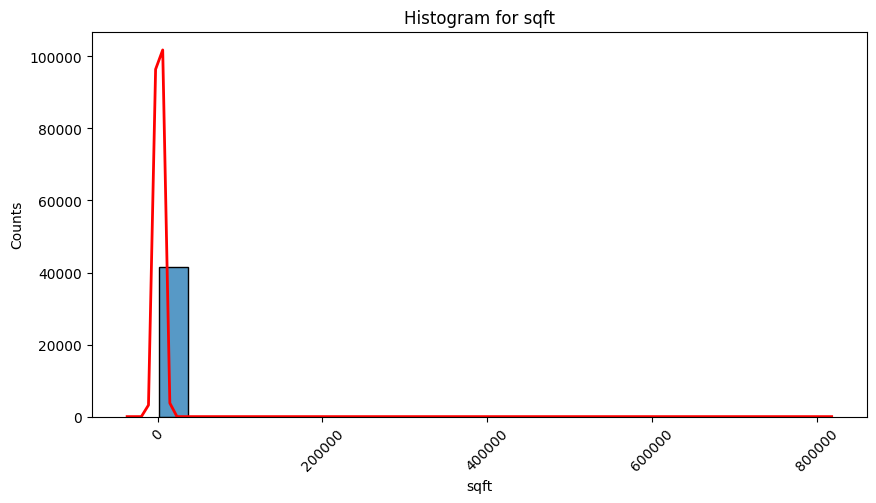

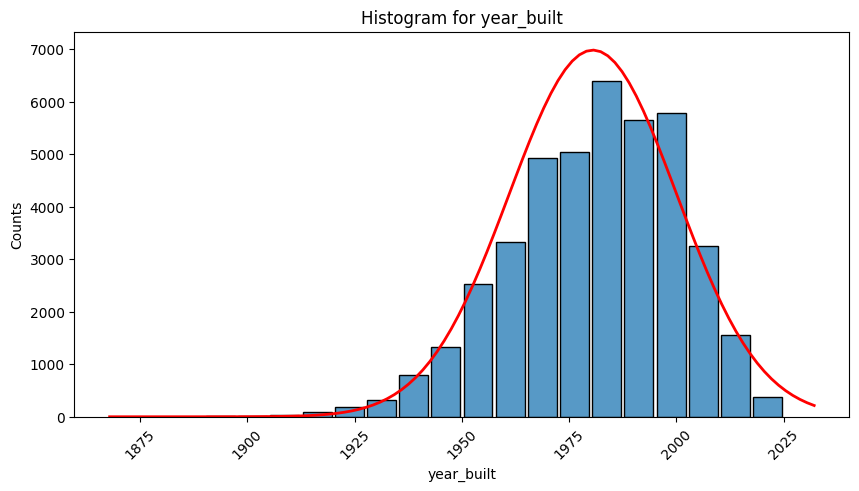

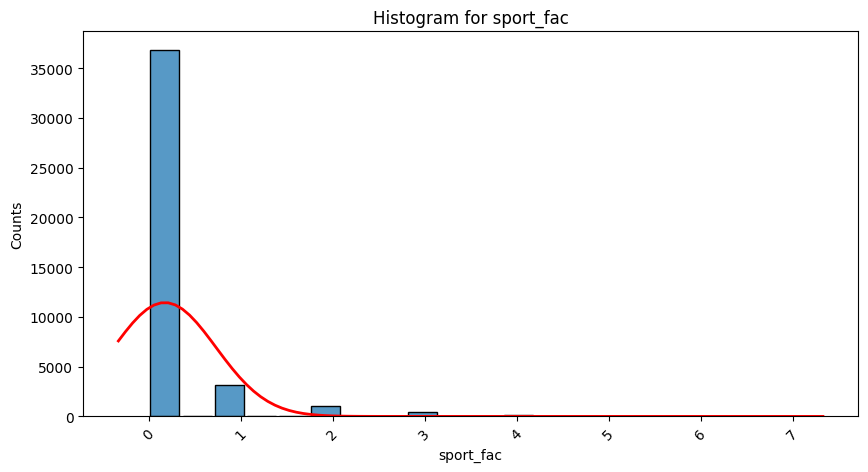

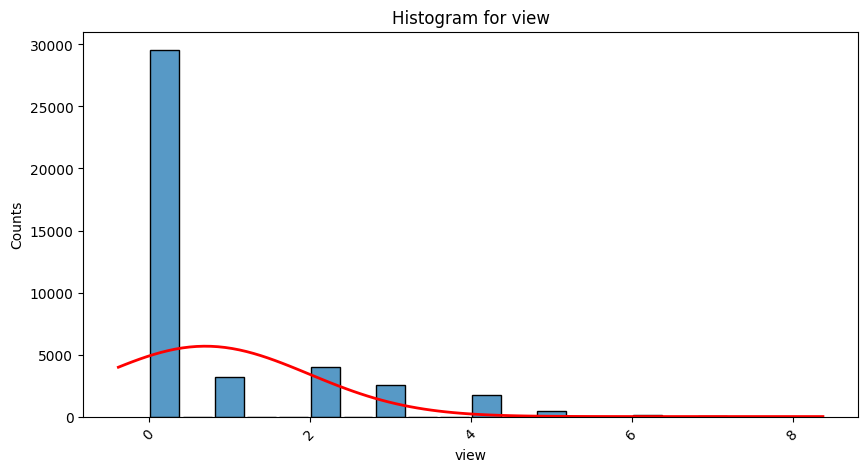

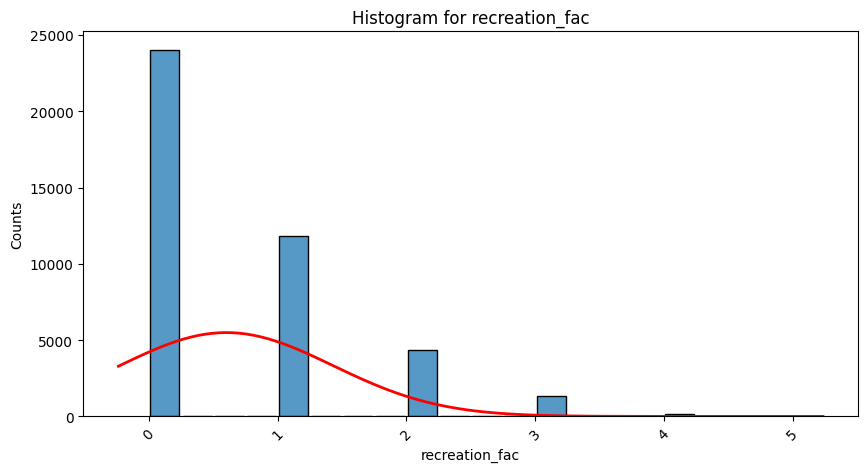

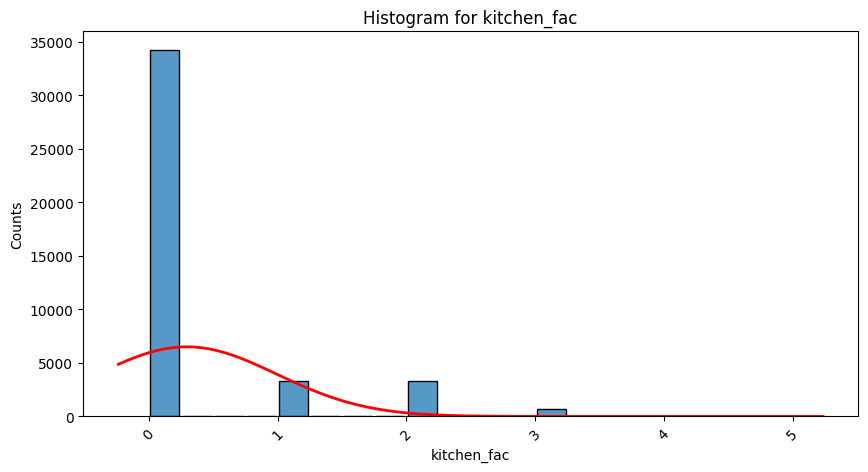

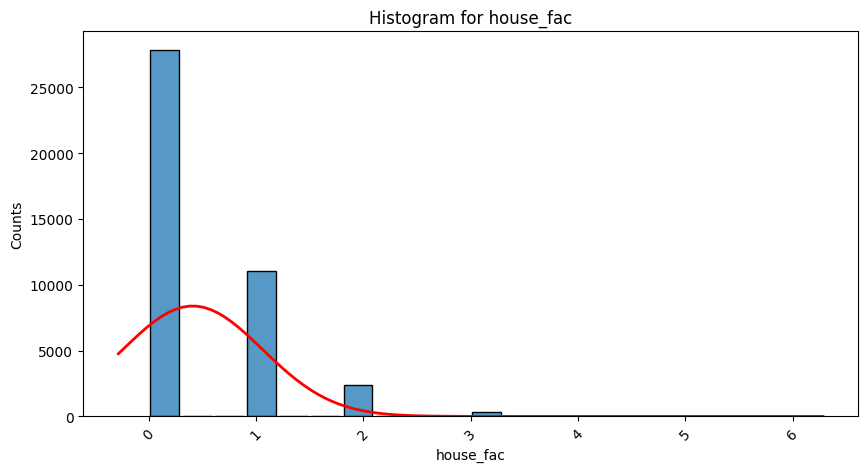

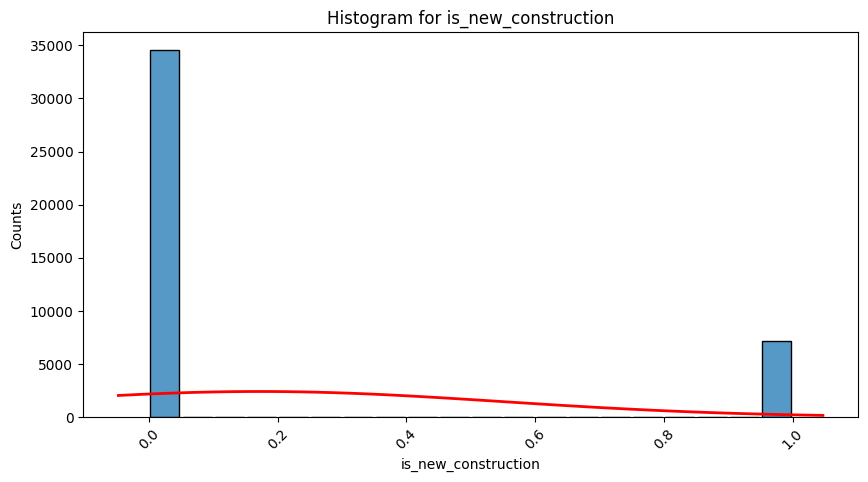

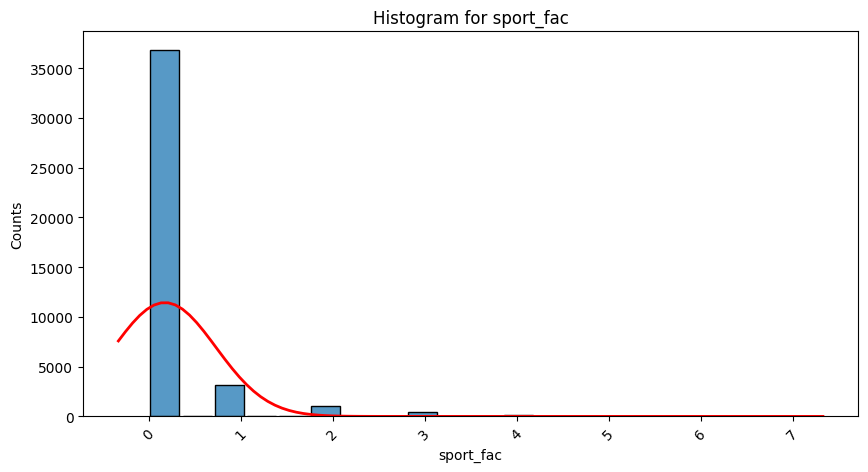

In [248]:
for col in forPlotHist:
    plot_histogram(data[col], col)

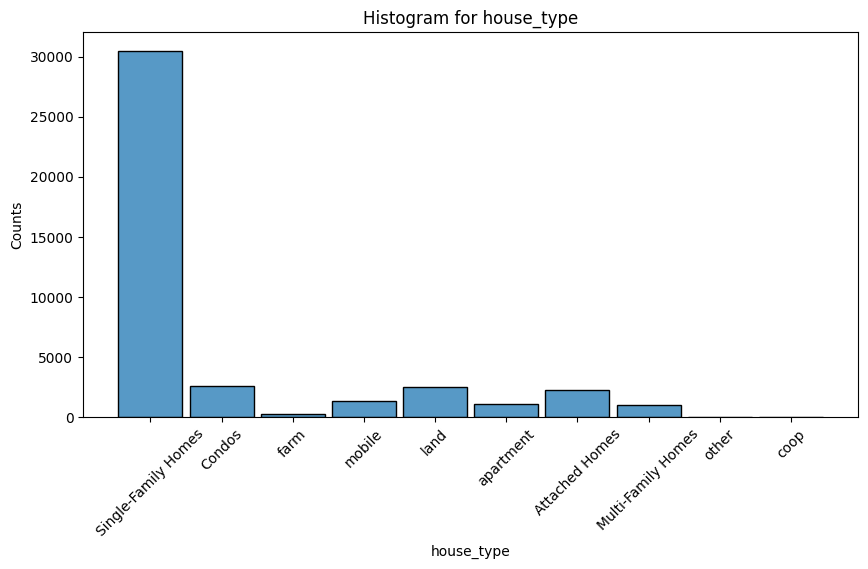

In [249]:
plot_histogram(data['house_type'], 'house_type', norm=False)

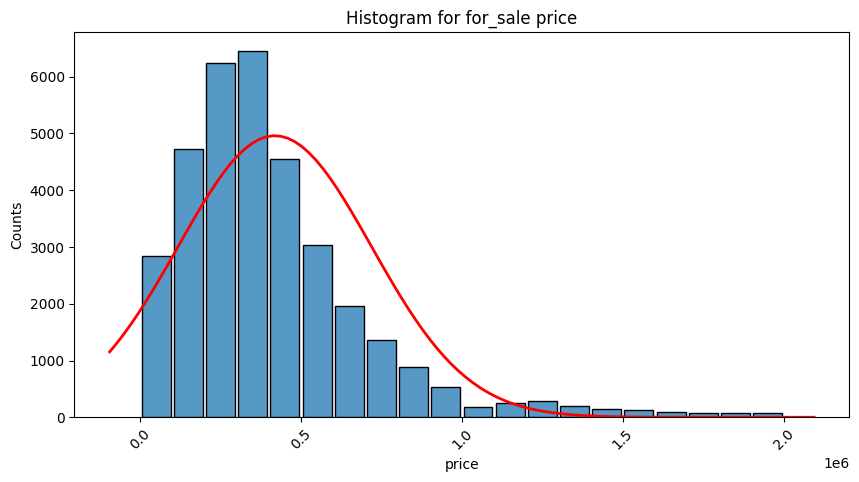

In [250]:
filteredPrices = data[(data['price'] < 2000000) & (data['status'] == 'for_sale')]
plot_histogram(filteredPrices['price'], 'for_sale price')

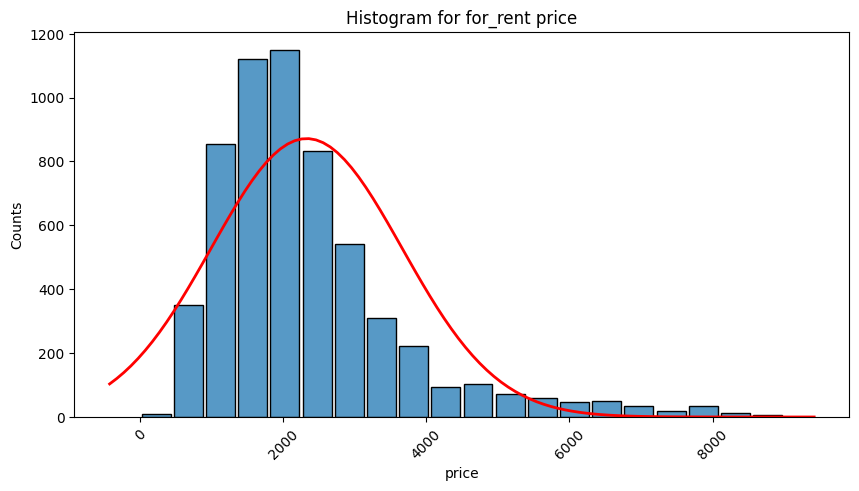

In [251]:
filteredPrices = data[(data['price'] < 9000) & (data['status'] == 'for_rent')]
plot_histogram(filteredPrices['price'], 'for_rent price')

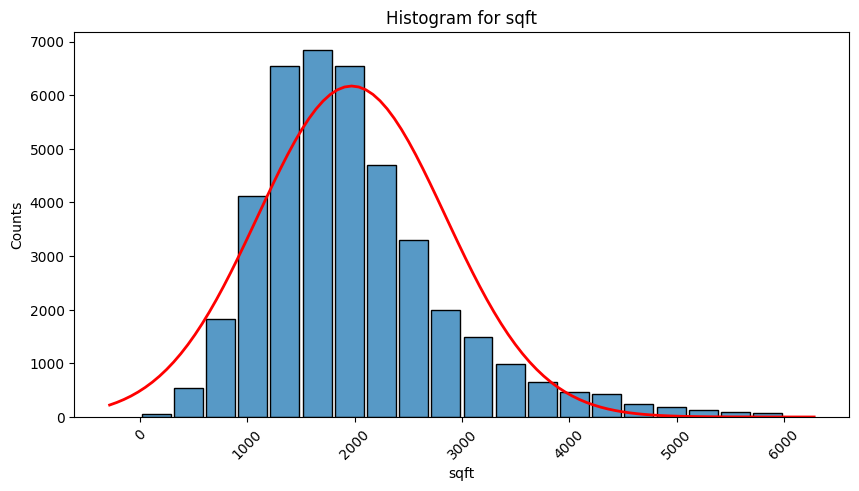

In [252]:
filteredSqft = data[data['sqft'] < 6000]
plot_histogram(filteredSqft['sqft'], 'sqft')

## Violin Plots

In [294]:
forPlotViolin = [
    'year_built',
    'sport_fac',
    'view',
    'recreation_fac',
    'kitchen_fac',
    'house_fac',
]

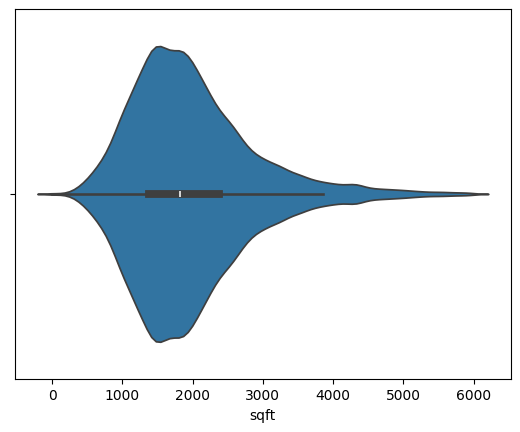

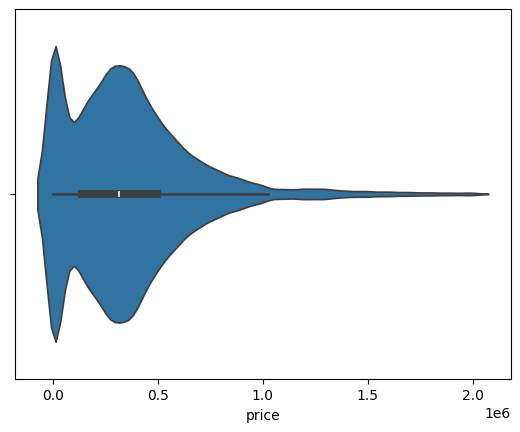

In [295]:
violinplot(data = data[data['sqft'] < 6000], x = 'sqft')
plt.show()
violinplot(data = data[data['price'] < 2000000], x = 'price')
plt.show()

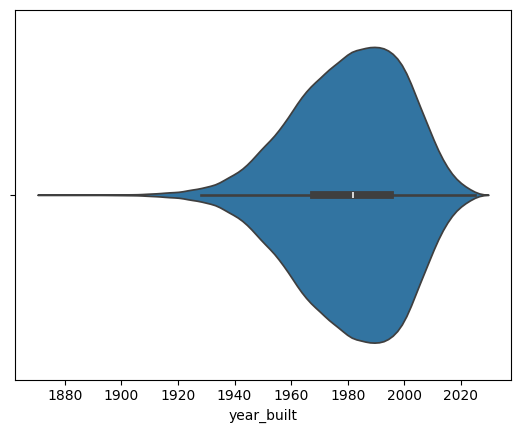

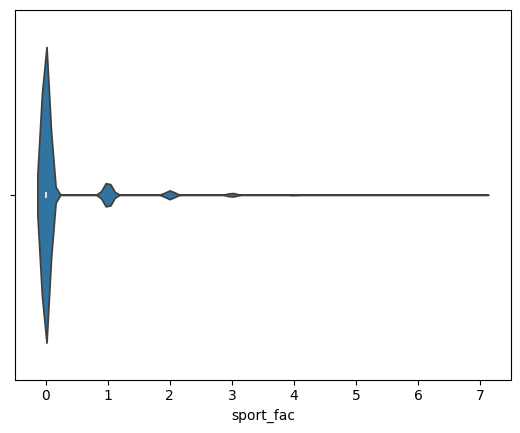

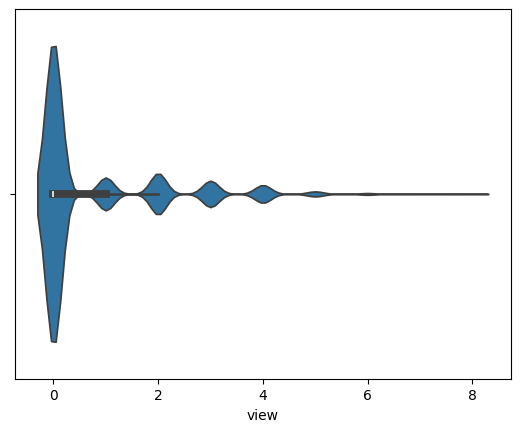

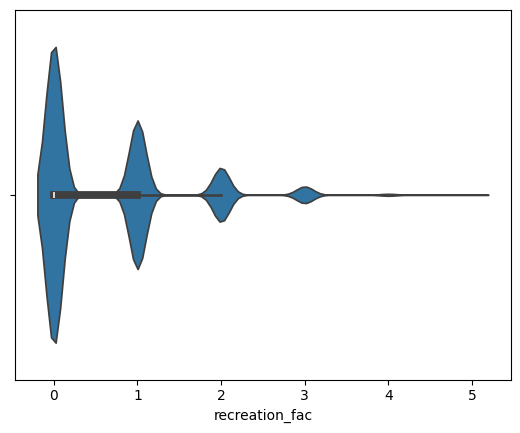

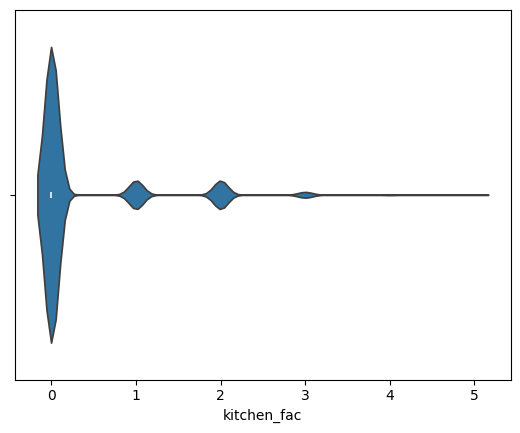

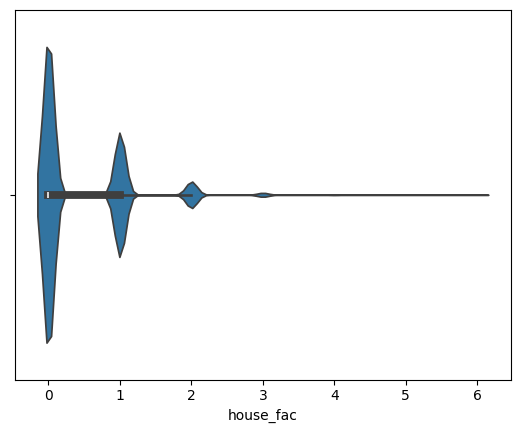

In [296]:
for to_plot in forPlotViolin:
    violinplot(data=data, x = to_plot)
    plt.show()

## Per State

C:\Users\asus\AppData\Local\Temp\ipykernel_20440\3190729815.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


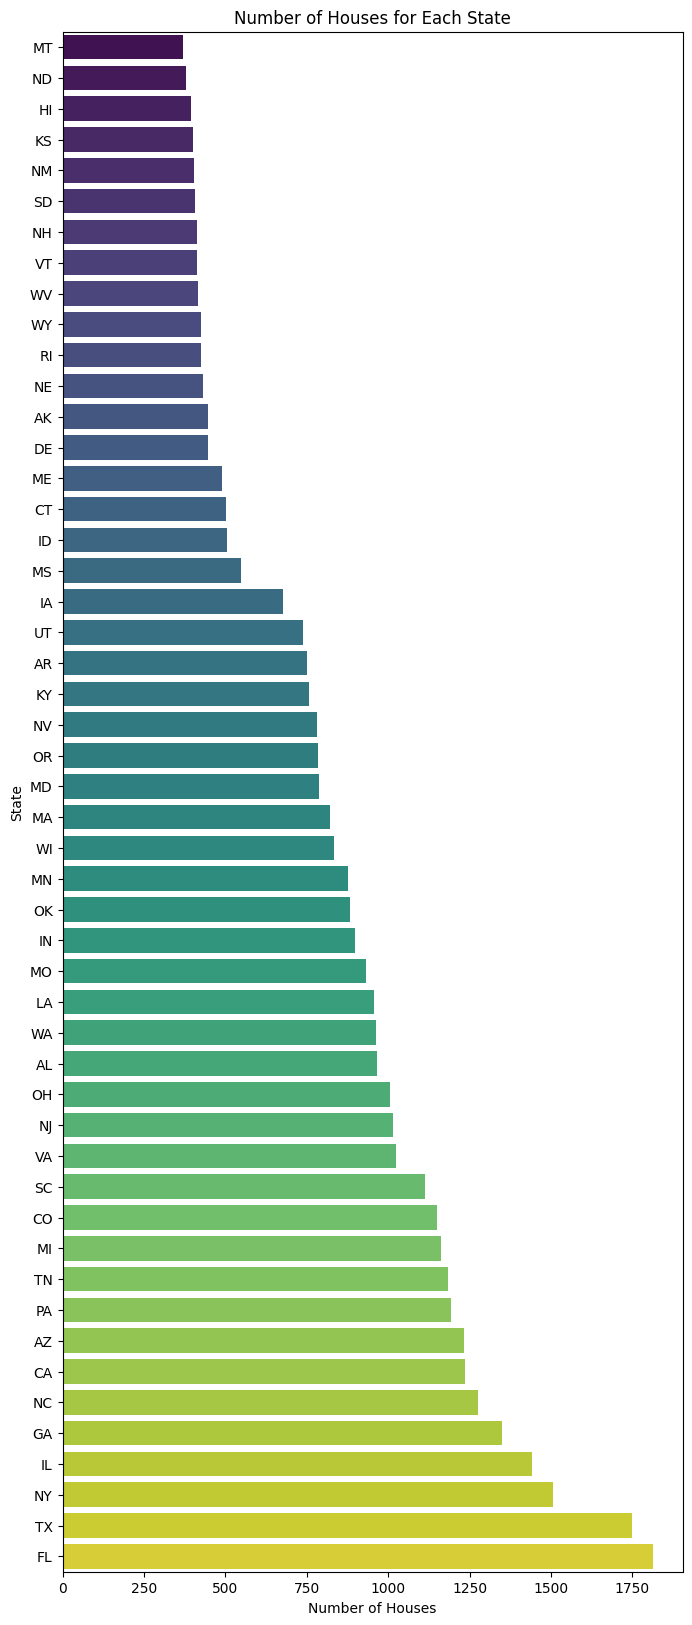

In [253]:
state_counts = data['state'].value_counts().reset_index()
state_counts.columns = ['state', 'house_count']
state_counts = state_counts.sort_values(by='house_count', ascending=True)

plt.figure(figsize=(8, 20))
sns.barplot(
    data=state_counts, 
    x='house_count', 
    y='state', 
    palette='viridis'
)
plt.xlabel('Number of Houses')
plt.ylabel('State')
plt.title('Number of Houses for Each State')
plt.show()

C:\Users\asus\AppData\Local\Temp\ipykernel_20440\4238746947.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


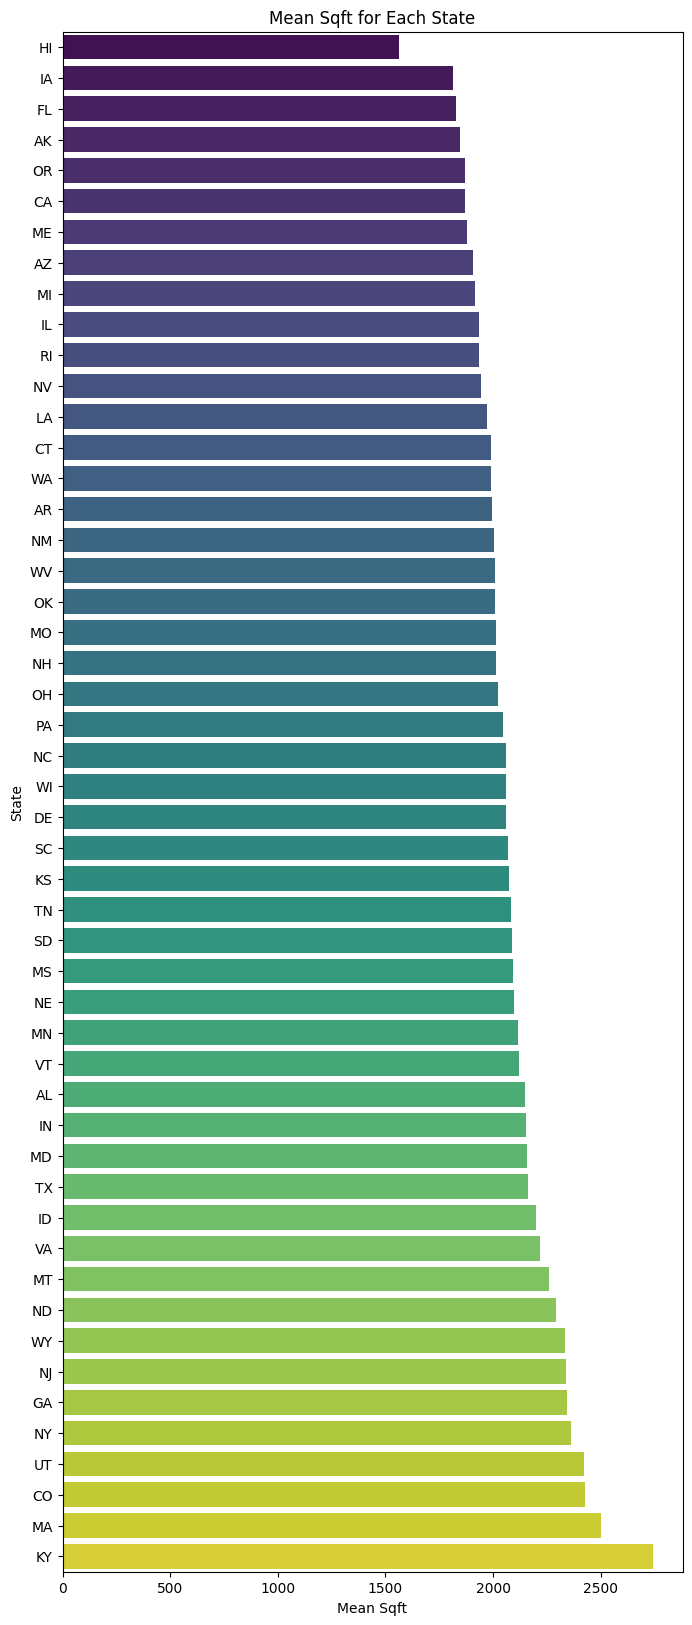

In [254]:
state_sqft_mean = data.groupby('state')['sqft'].mean().reset_index()

state_sqft_mean = state_sqft_mean.sort_values(by='sqft', ascending=True)

plt.figure(figsize=(8, 20))
sns.barplot(
    data=state_sqft_mean, 
    x='sqft', 
    y='state', 
    palette='viridis'
)
plt.xlabel('Mean Sqft')
plt.ylabel('State')
plt.title('Mean Sqft for Each State')
plt.show()

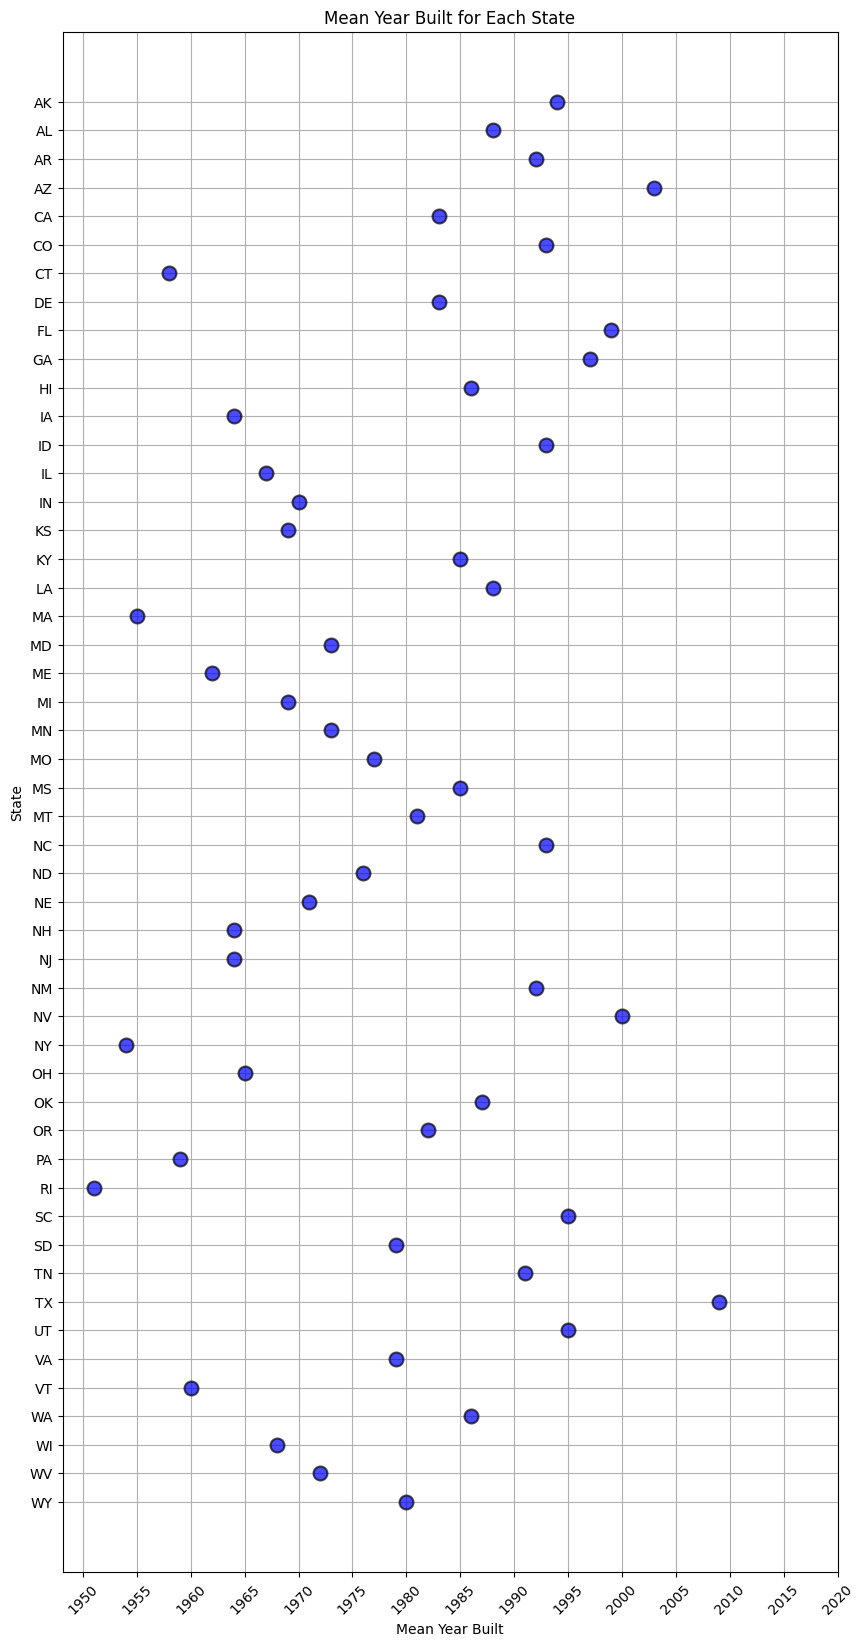

In [255]:
state_year_built_mean = data.groupby('state')['year_built'].mean().reset_index()

state_year_built_mean['year_built'] = np.ceil(state_year_built_mean['year_built']).astype(int)

plt.figure(figsize=(10, 20))
sns.scatterplot(data=state_year_built_mean, x='year_built', y='state', s=100, color='blue', alpha=0.7, edgecolor='black', linewidth=1.5)
plt.xticks(rotation=45)
plt.xticks(range(1950, 2021, 5))

plt.xlabel('Mean Year Built')
plt.ylabel('State')
plt.title('Mean Year Built for Each State')
plt.grid(True)
plt.gca().set_axisbelow(True)
plt.show()

C:\Users\asus\AppData\Local\Temp\ipykernel_20440\1748979986.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  barplot(


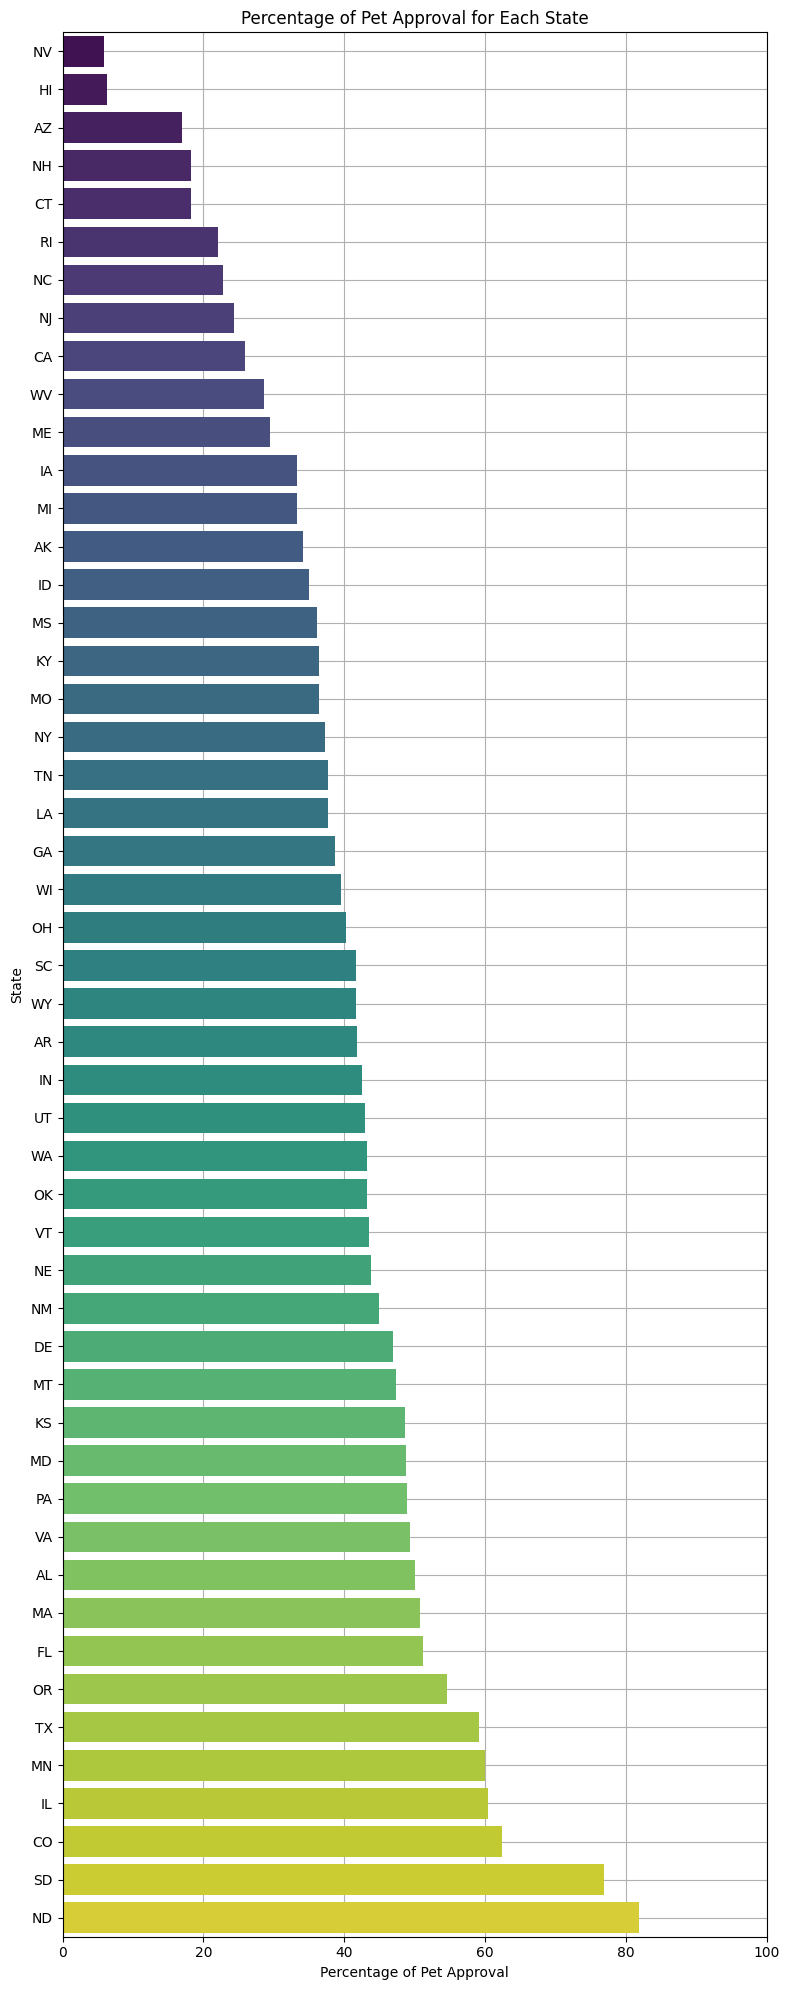

In [256]:
figure, ax = plt.subplots(figsize = (8, 20))
allowed_pet_percentage = data[(data['status'] == 'for_rent')].groupby('state')['pet'].mean().reset_index()
allowed_pet_percentage['pet'] *= 100
allowed_pet_percentage = allowed_pet_percentage.sort_values(by='pet', ascending=True)

barplot(
    data = allowed_pet_percentage,
    x='pet',
    y='state',
    palette='viridis',
    legend=False
)
plt.xlim(0, 100)
plt.xlabel('Percentage of Pet Approval')
plt.ylabel('State')
plt.title('Percentage of Pet Approval for Each State')

plt.grid(True)
plt.gca().set_axisbelow(True)
plt.tight_layout()
plt.show()


C:\Users\asus\AppData\Local\Temp\ipykernel_20440\2579845923.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


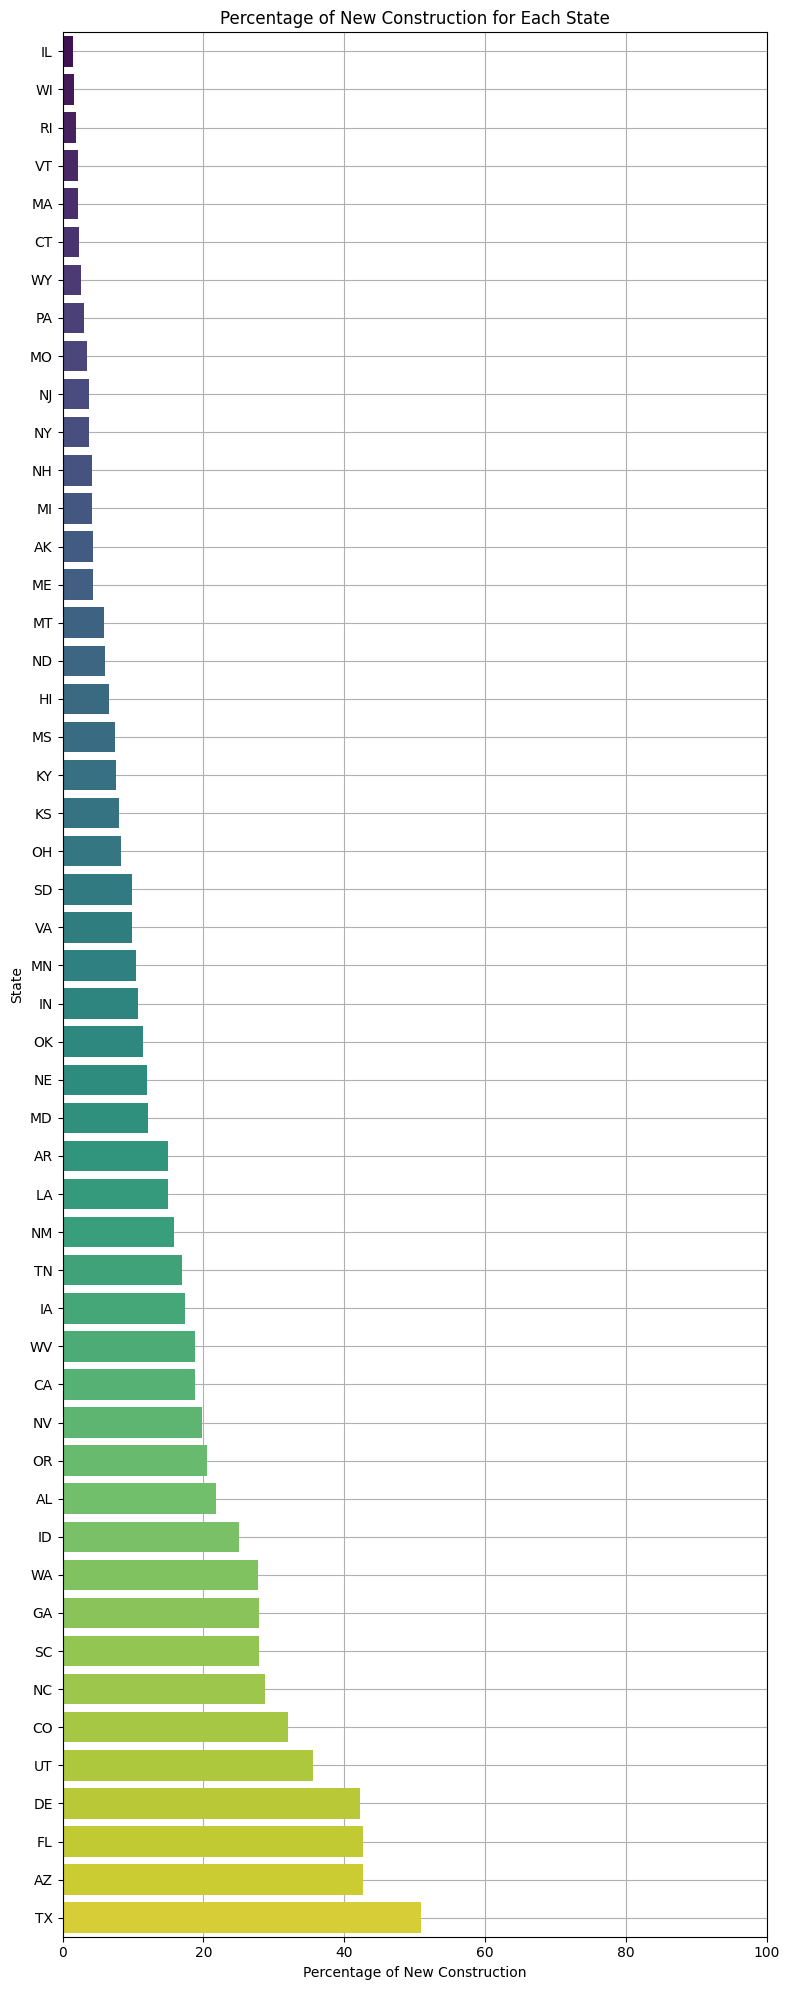

In [257]:
state_new_construction_percentage = data.groupby('state')['is_new_construction'].mean().reset_index()
state_new_construction_percentage['is_new_construction'] *= 100
state_new_construction_percentage = state_new_construction_percentage.sort_values(by='is_new_construction', ascending=True)

plt.figure(figsize=(8, 20))
sns.barplot(
    data=state_new_construction_percentage, 
    x='is_new_construction', 
    y='state', 
    palette='viridis'
)
plt.xlabel('Percentage of New Construction')
plt.ylabel('State')
plt.title('Percentage of New Construction for Each State')
plt.xlim(0, 100)

plt.grid(True)
plt.gca().set_axisbelow(True)
plt.tight_layout()
plt.show()

C:\Users\asus\AppData\Local\Temp\ipykernel_20440\3355280212.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


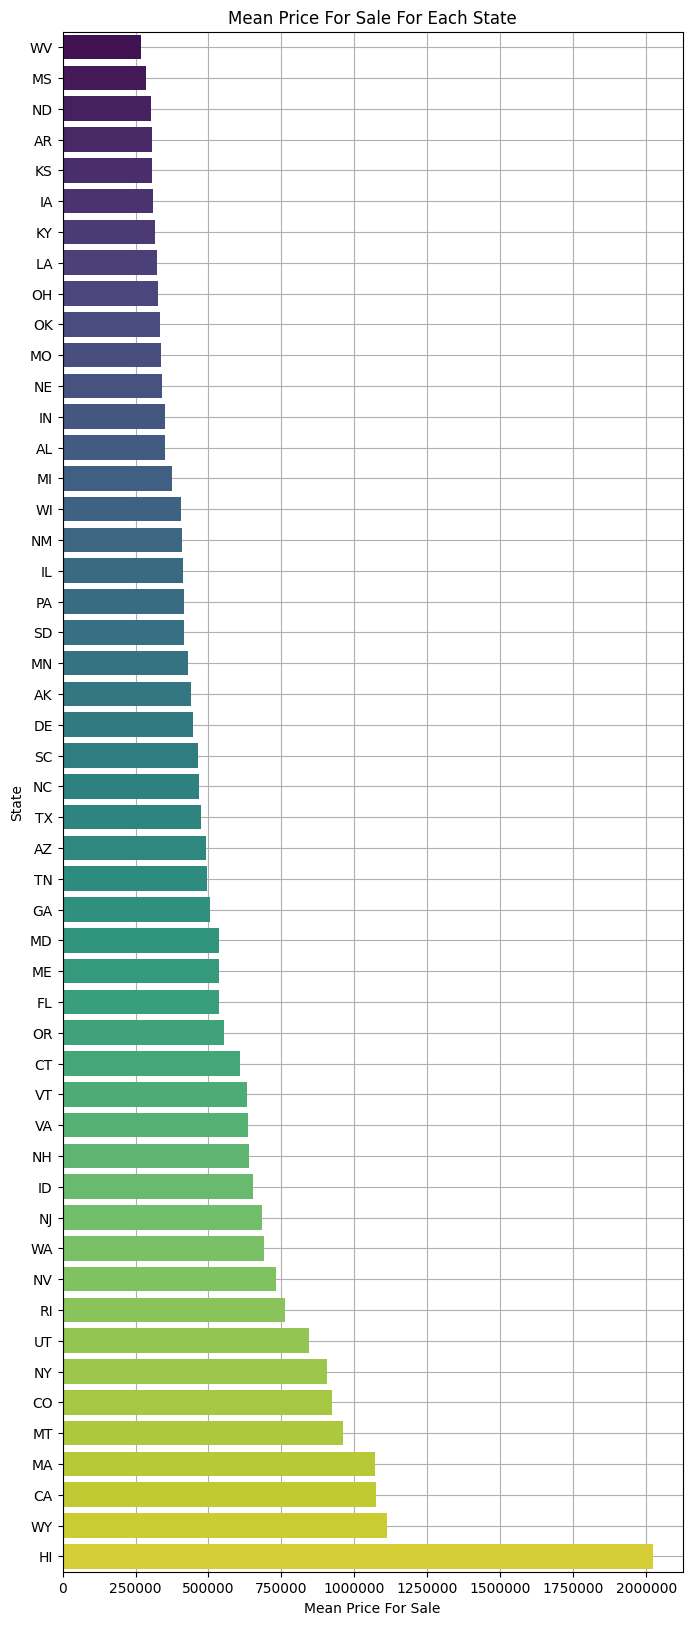

In [258]:
state_sqft_mean = data[data['status'] == 'for_sale'].groupby('state')['price'].mean().reset_index()

state_sqft_mean = state_sqft_mean.sort_values(by='price', ascending=True)

plt.figure(figsize=(8, 20))
sns.barplot(
    data=state_sqft_mean, 
    x='price', 
    y='state', 
    palette='viridis'
)
plt.xlabel('Mean Price For Sale')
plt.ylabel('State')
plt.title('Mean Price For Sale For Each State')

plt.grid(True)
plt.gca().set_axisbelow(True)
plt.gca().ticklabel_format(style='plain', axis='x')
plt.show()


C:\Users\asus\AppData\Local\Temp\ipykernel_20440\3877101422.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


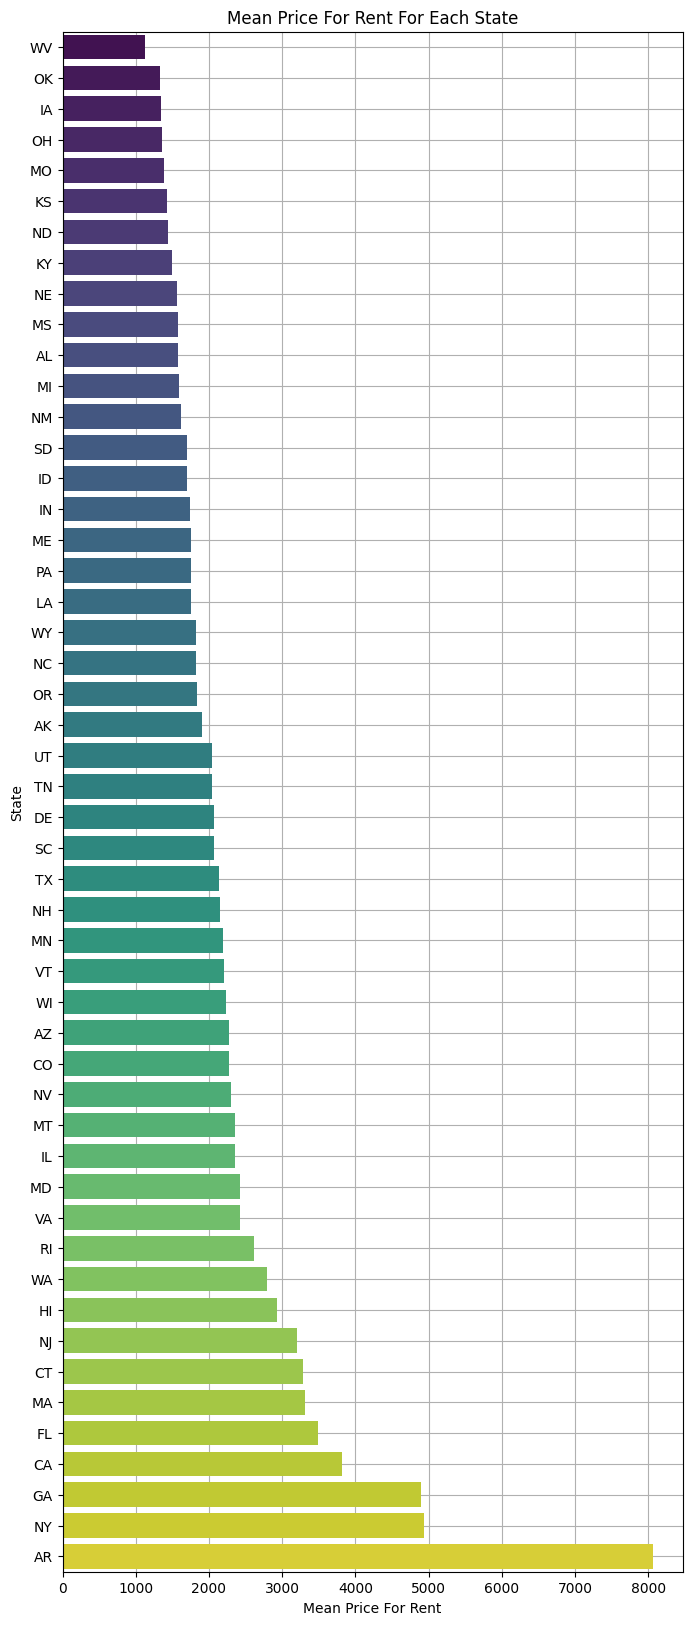

In [259]:
state_sqft_mean = data[data['status'] == 'for_rent'].groupby('state')['price'].mean().reset_index()

state_sqft_mean = state_sqft_mean.sort_values(by='price', ascending=True)

plt.figure(figsize=(8, 20))
sns.barplot(
    data=state_sqft_mean, 
    x='price', 
    y='state', 
    palette='viridis'
)
plt.xlabel('Mean Price For Rent')
plt.ylabel('State')
plt.title('Mean Price For Rent For Each State')

plt.grid(True)
plt.gca().set_axisbelow(True)
plt.gca().ticklabel_format(style='plain', axis='x')
plt.show()


In [260]:
def plot_barplot_categorical_numeric_relation(data: pd.DataFrame, numeric_col: str, category_col: str, label: str):
    # plt.figure(figsize=(6, 6))
    figure, axes = plt.subplots(ncols = 2, nrows = 1, figsize=(16,6))
    barplot(
        data = data[data['status'] == 'for_sale'],
        x = category_col,
        y = numeric_col,
        estimator = 'mean',
        order = data[data['status'] == 'for_sale'].groupby(category_col)[numeric_col].mean().index.to_list(),
        ax = axes[0]
    )
    barplot(
        data = data[data['status'] == 'for_rent'],
        x = category_col,
        y = numeric_col,
        estimator = 'mean',
        order = data[data['status'] == 'for_rent'].groupby(category_col)[numeric_col].mean().index.to_list(),
        ax = axes[1]
    )
    axes[0].set_title("for_sale") 
    axes[1].set_title("for_rent") 
    # plt.tick_params(axis='x', rotation=45)
    plt.ylabel('price')
    for ax in axes:
        ax.tick_params(axis='x', rotation=45)
        ax.set_ylabel('price')
    plt.show()

## Against Price

In [261]:
againstPriceCols = [
    'beds',
    'baths',
    'garage',
    'stories',
    'house_type',
    'is_new_construction',
    'sport_fac',
    'kitchen_fac',
    'house_fac',
    'view'
]

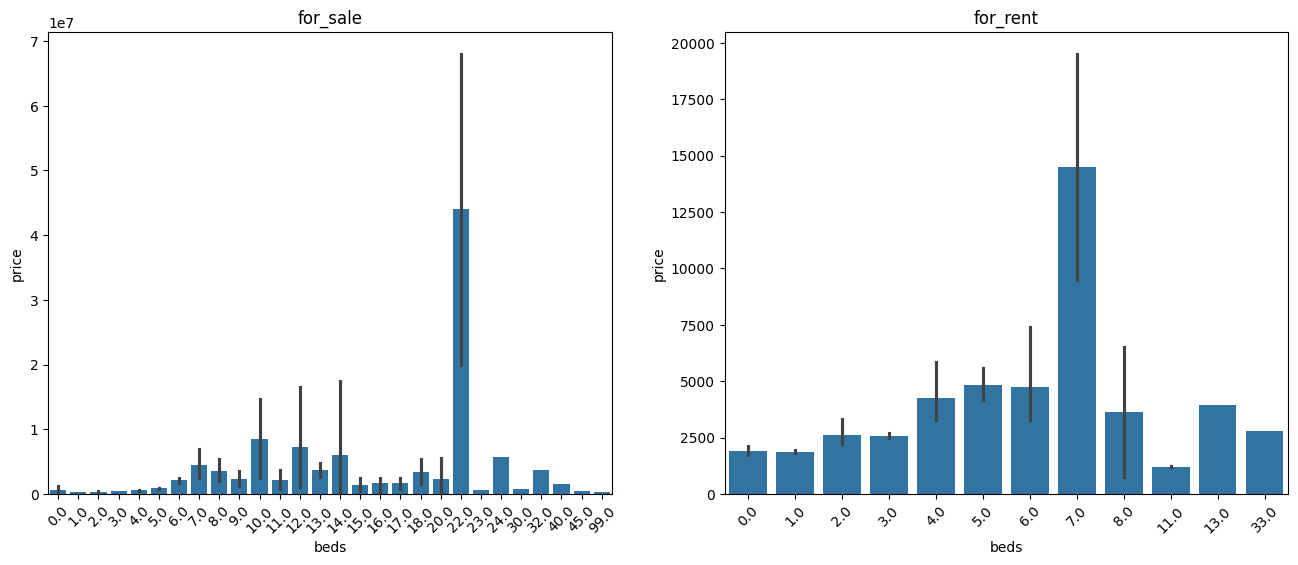

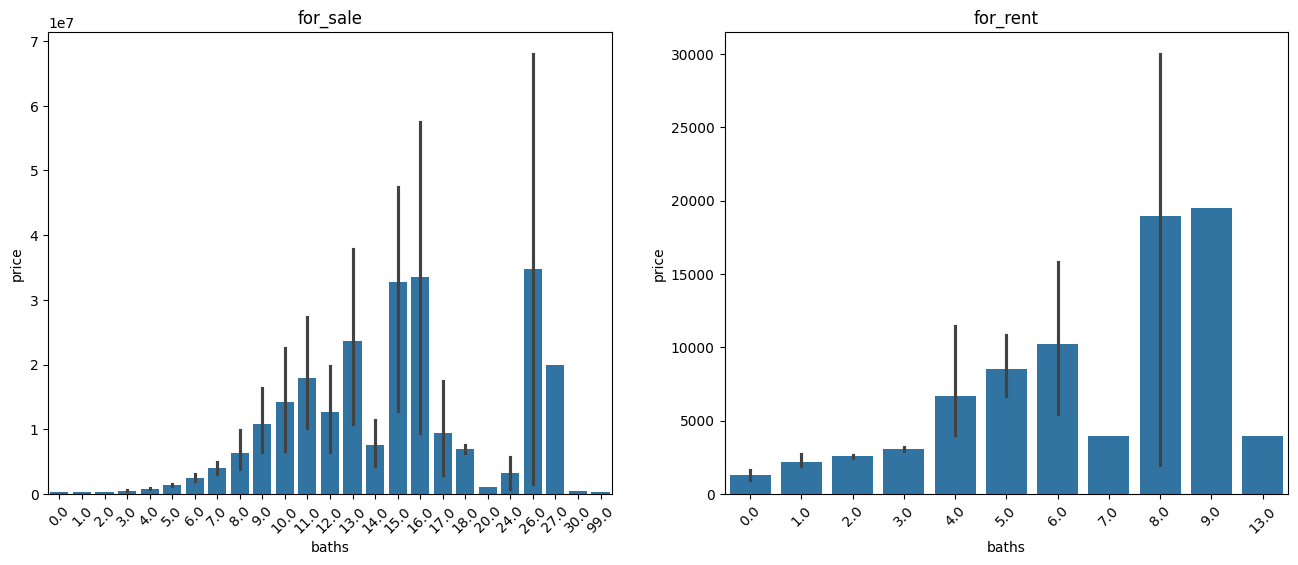

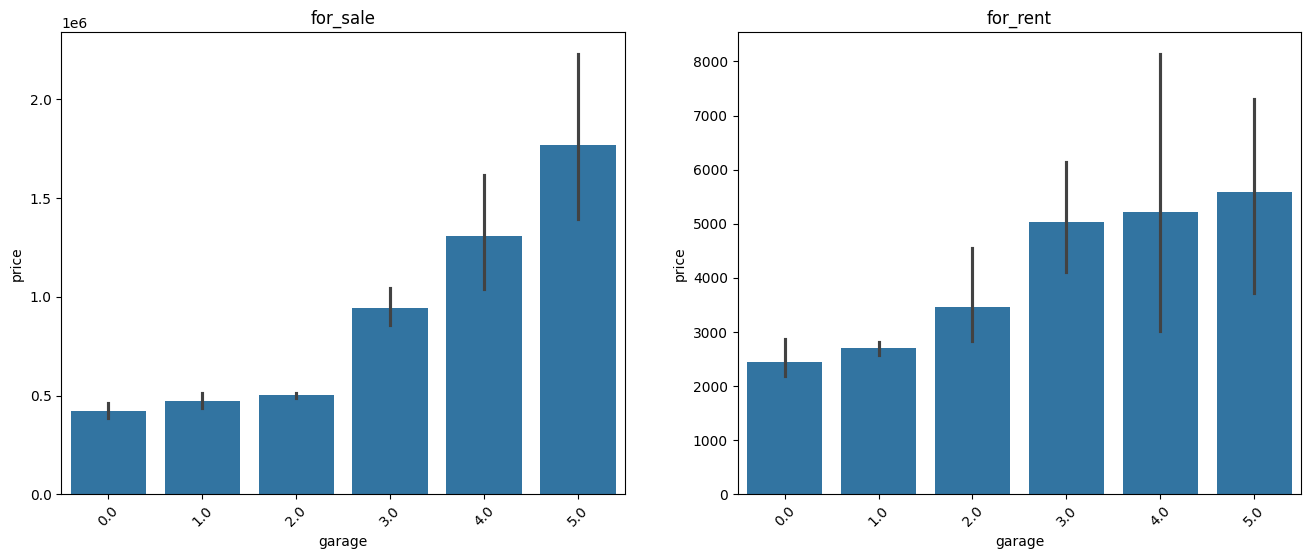

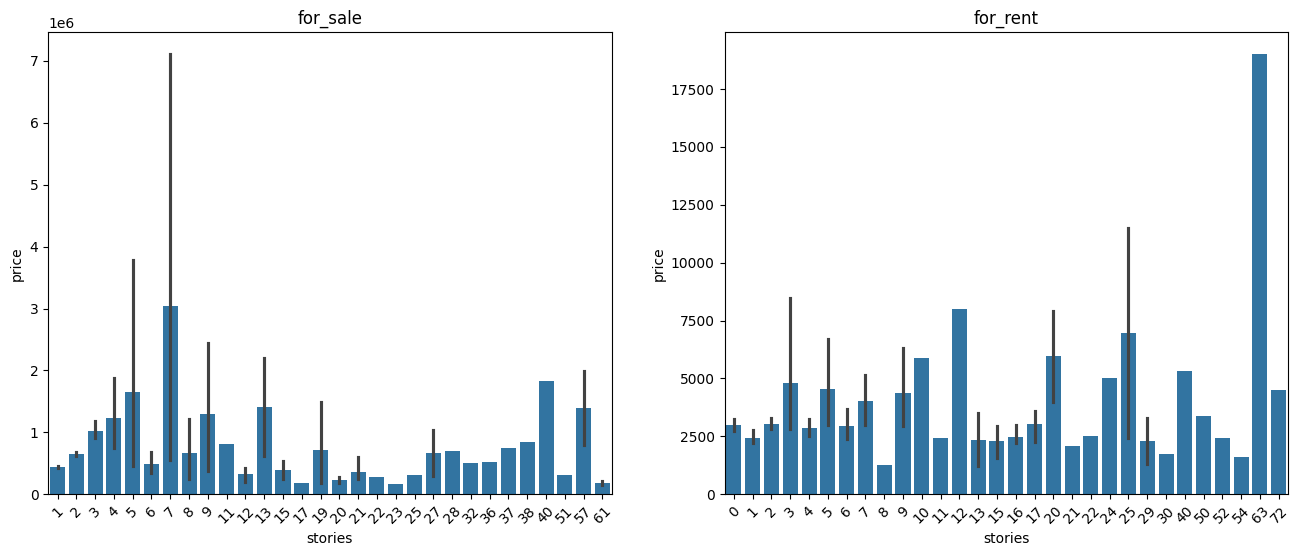

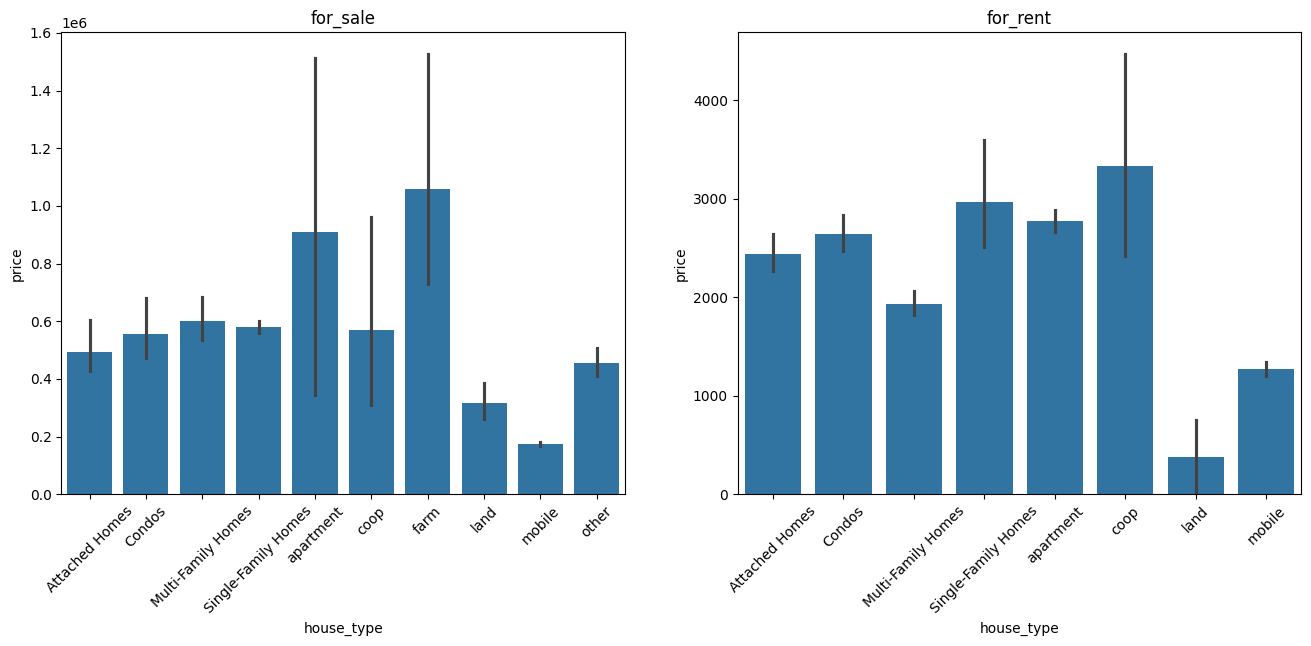

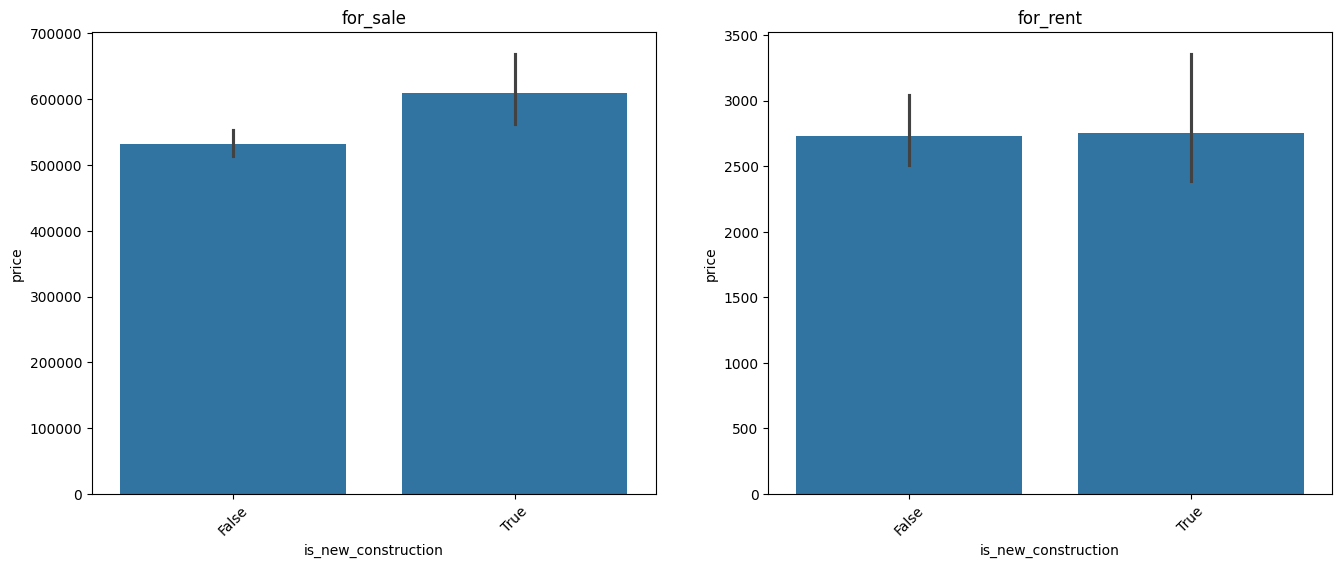

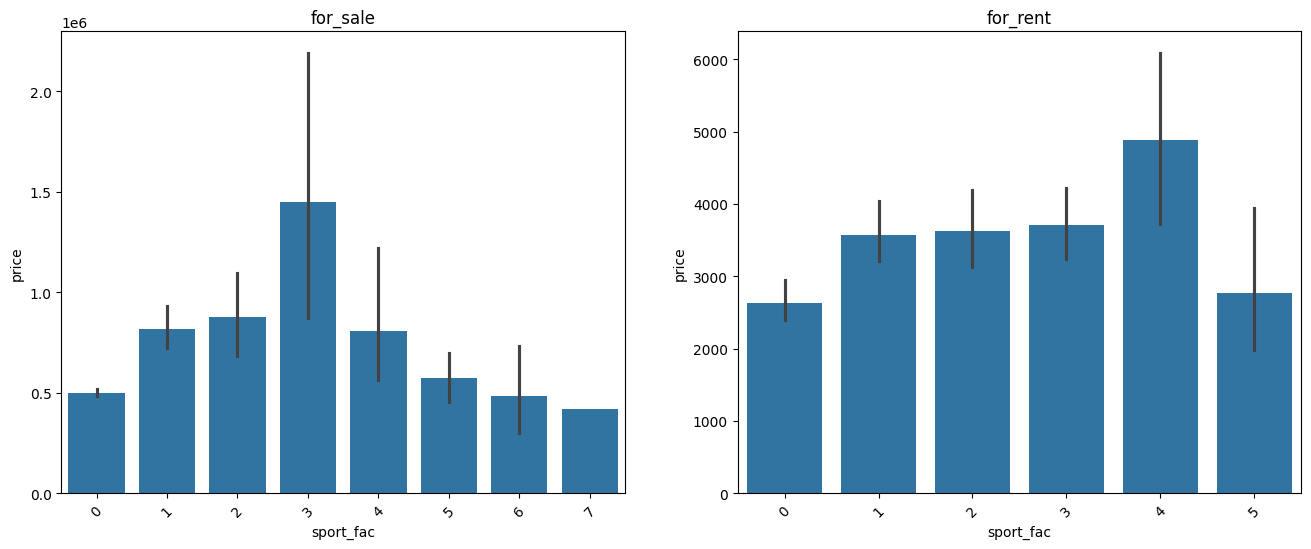

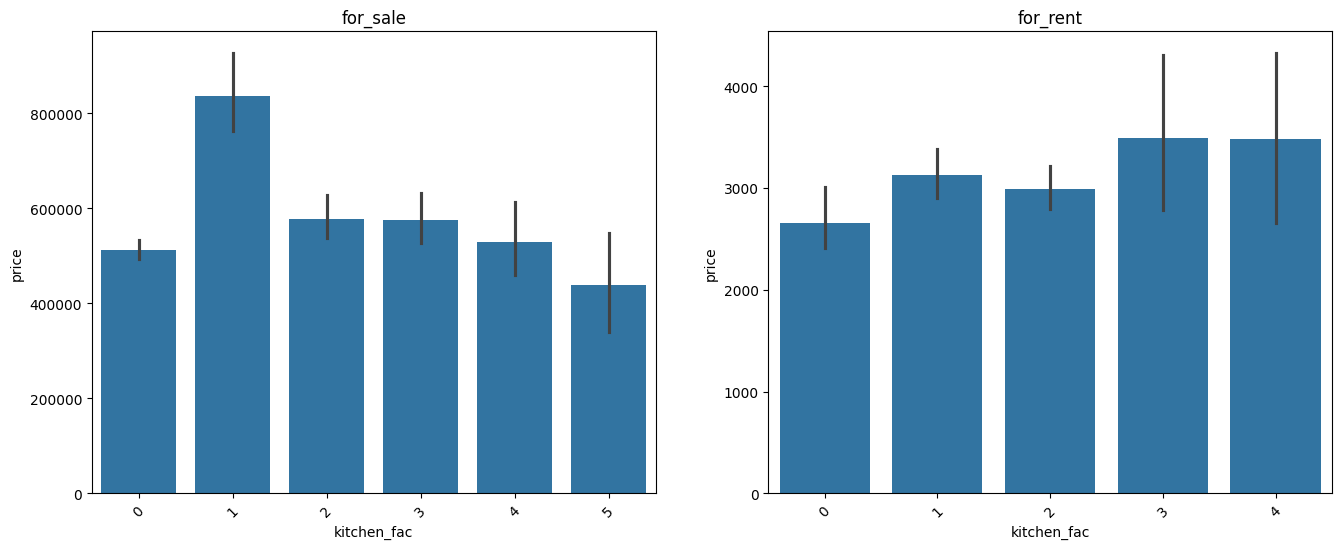

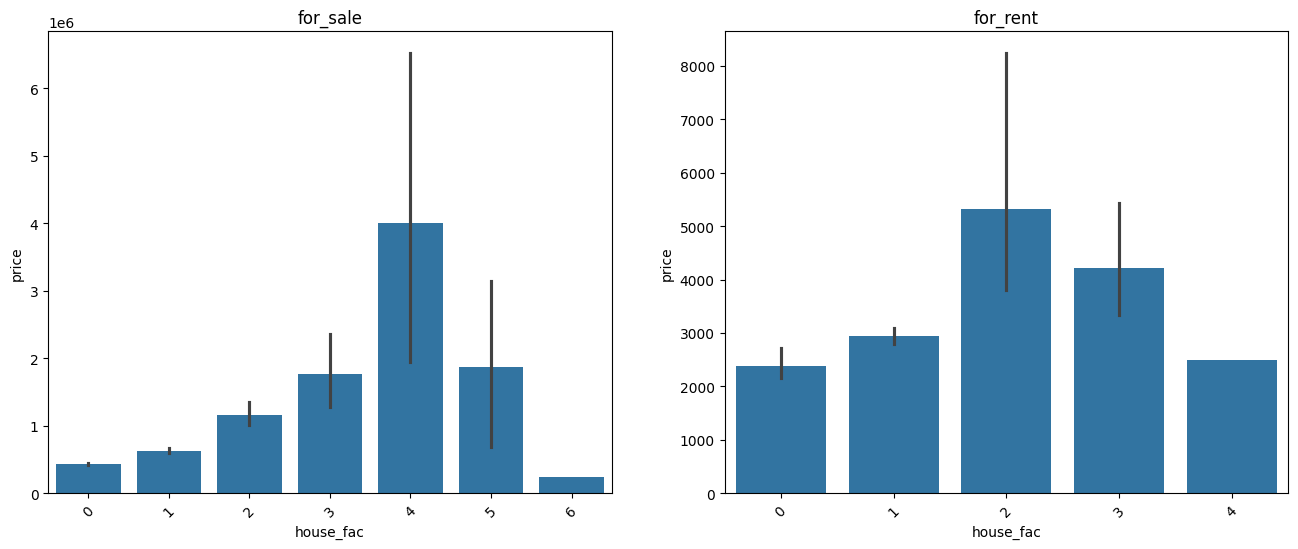

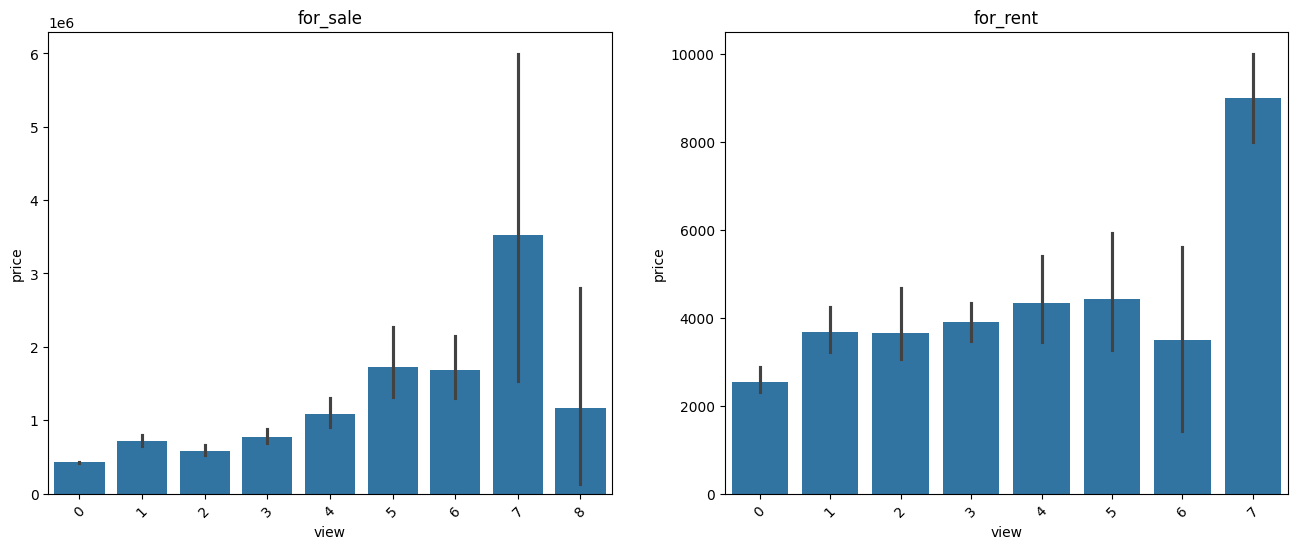

In [262]:
for col in againstPriceCols:
    plot_barplot_categorical_numeric_relation(
        data = data,
        numeric_col = 'price',
        category_col = col,
        label = "for_sale"
    )

## Against Built Decade

In [263]:
againstDecadeCols = [
    'house_type',
    'central_heat',
    'central_air',
    'status',
    'view',
    'beds',
    'baths'
]

In [264]:
def group_by_decade(year):
    return str(int(year // 10 * 10)) + "s"

def group_by_sqft(sqft):
    return int(sqft // 2000 * 2000)

def stacked_barplot(data, index, column):
    pivot_table = pd.pivot_table(data, index=index, columns=column, aggfunc='size', fill_value=0)
    percentage_df = pivot_table.div(pivot_table.sum(axis=1), axis=0) * 100
    percentage_df.plot(kind='bar', stacked=True, figsize=(10, 6))

    plt.title(f'Percentage of {column} Over {index}')
    plt.xlabel(f'{index}')
    plt.ylabel('Percentage')
    plt.legend(title=f'{column}')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

In [265]:
dec_data = data.copy(deep=True)
dec_data['decade_built'] = data['year_built'].apply(group_by_decade)
dec_data = dec_data[(dec_data['beds'] < 12) & (dec_data['baths'] < 12)& (dec_data['baths'] < 12)]

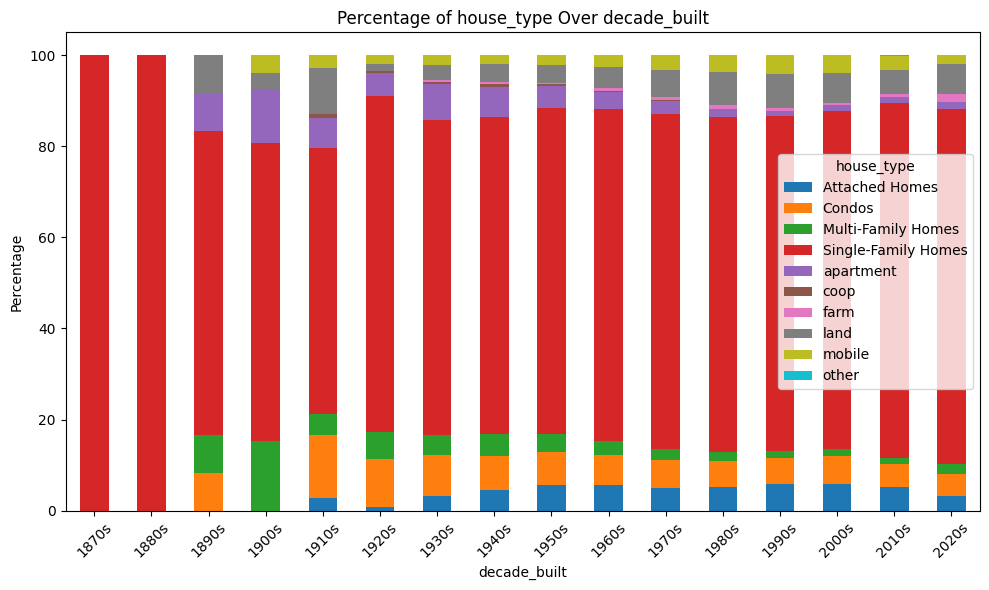

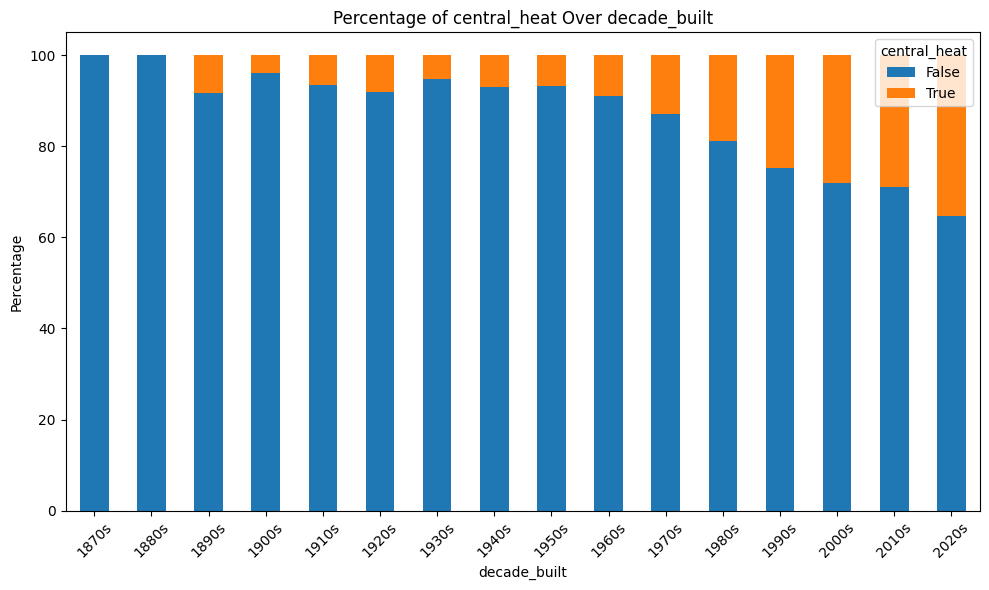

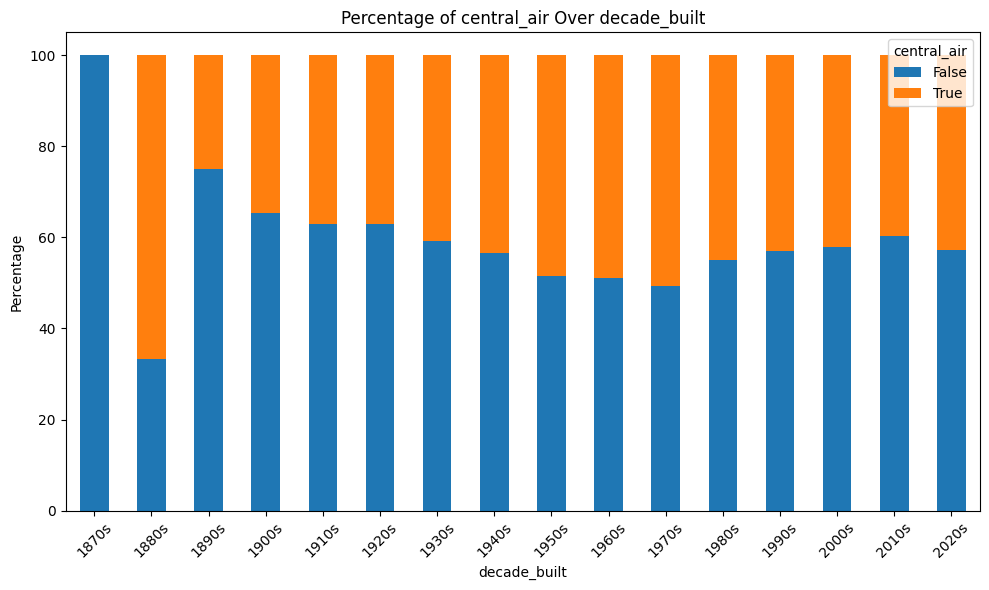

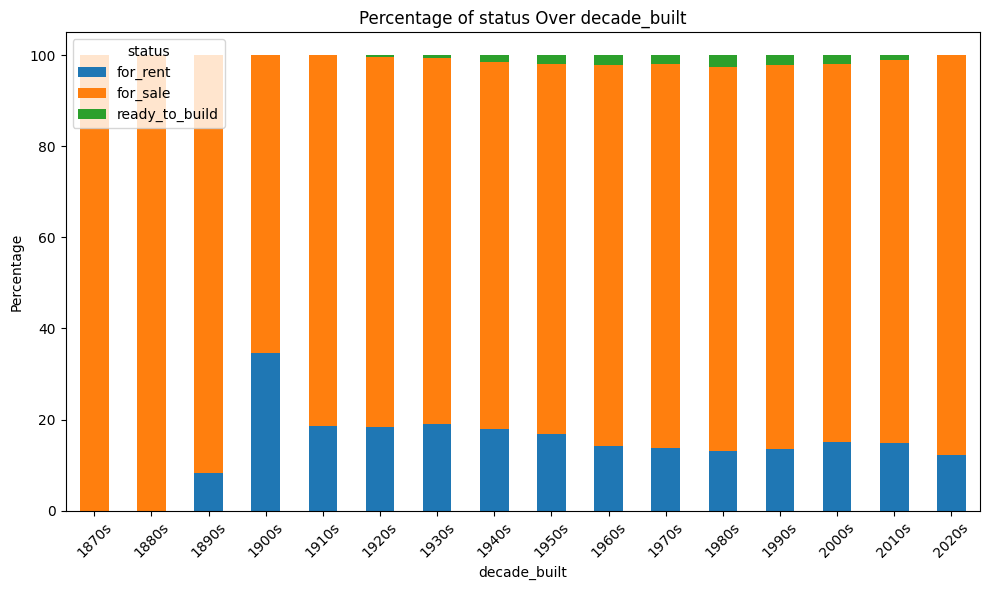

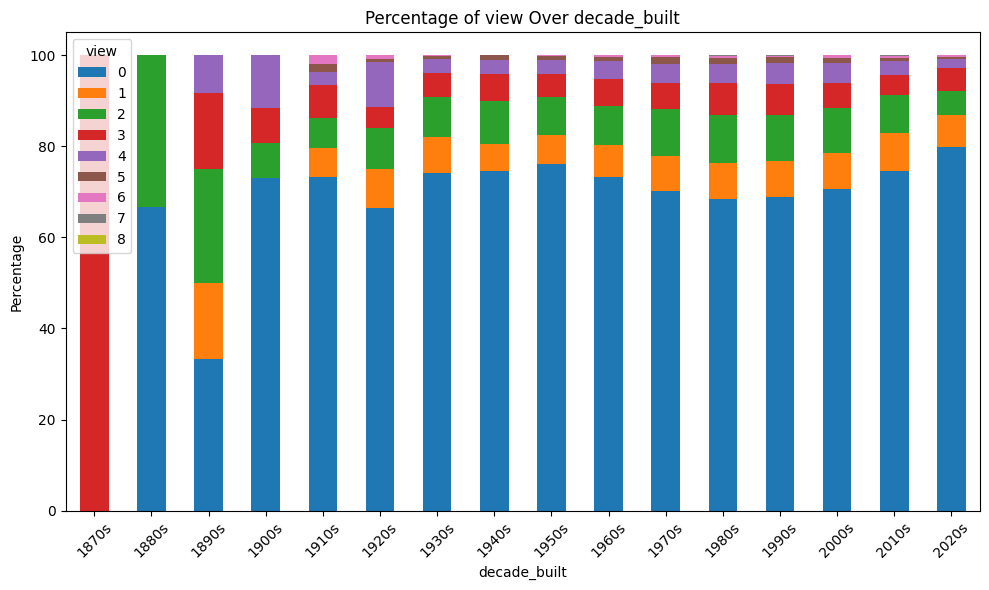

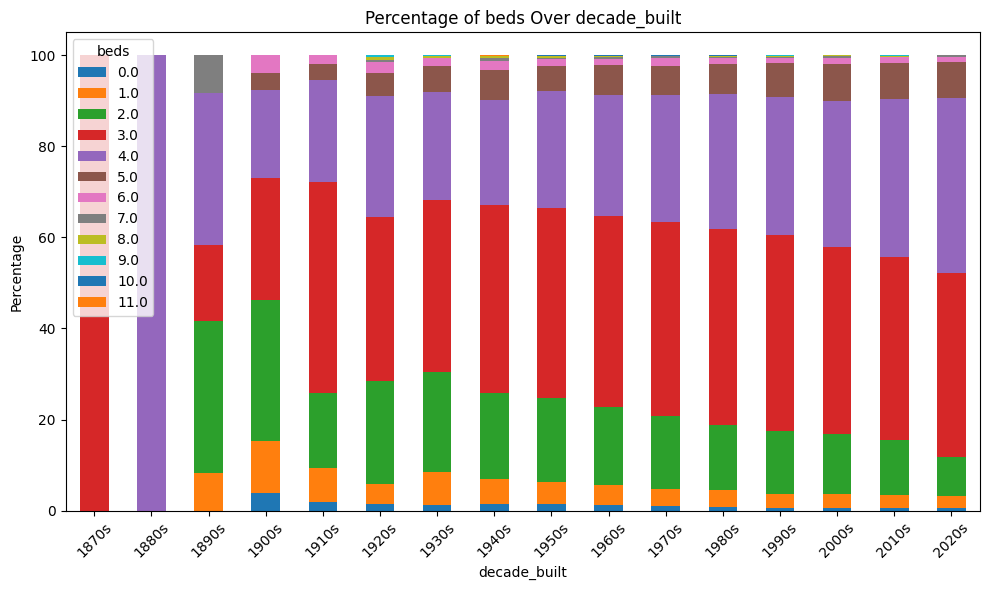

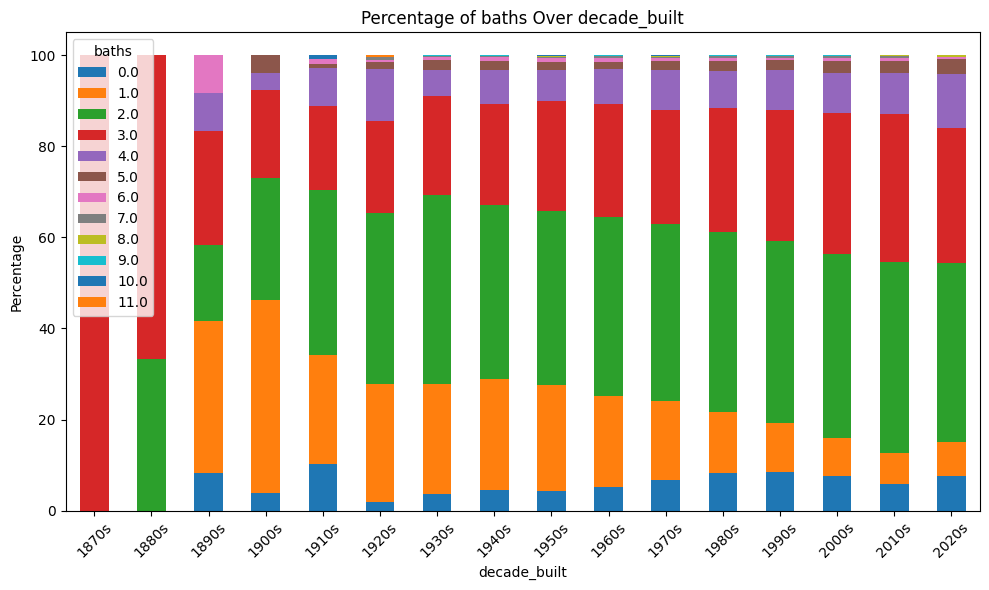

In [266]:
for col in againstDecadeCols:
    stacked_barplot(dec_data, 'decade_built', col)

## Against Grouped Sqft

In [267]:
againstSqftCols = [
    'house_type',
    'central_heat',
    'central_air',
    'status',
    'view',
    'beds',
    'baths'
]

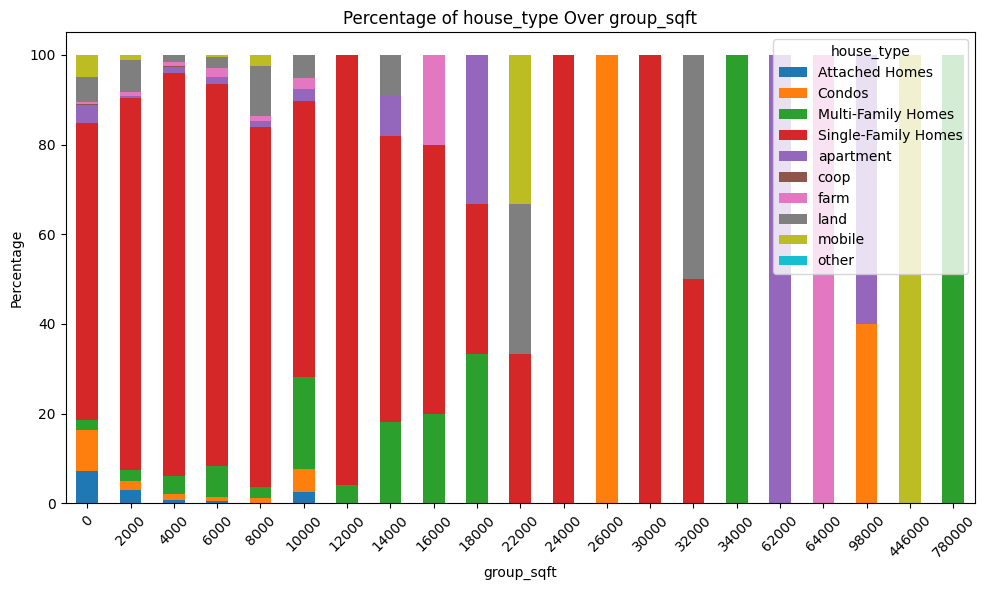

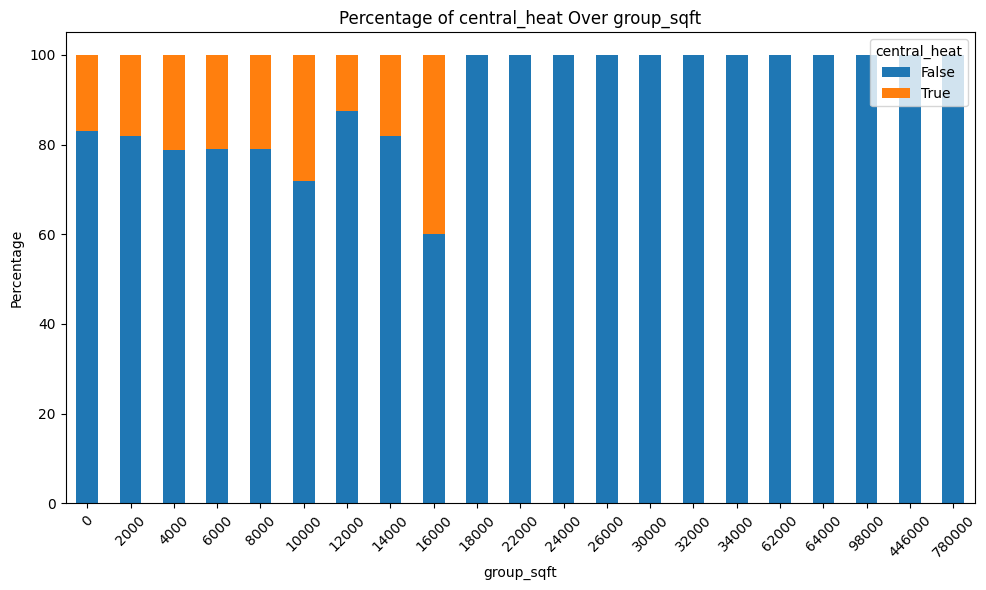

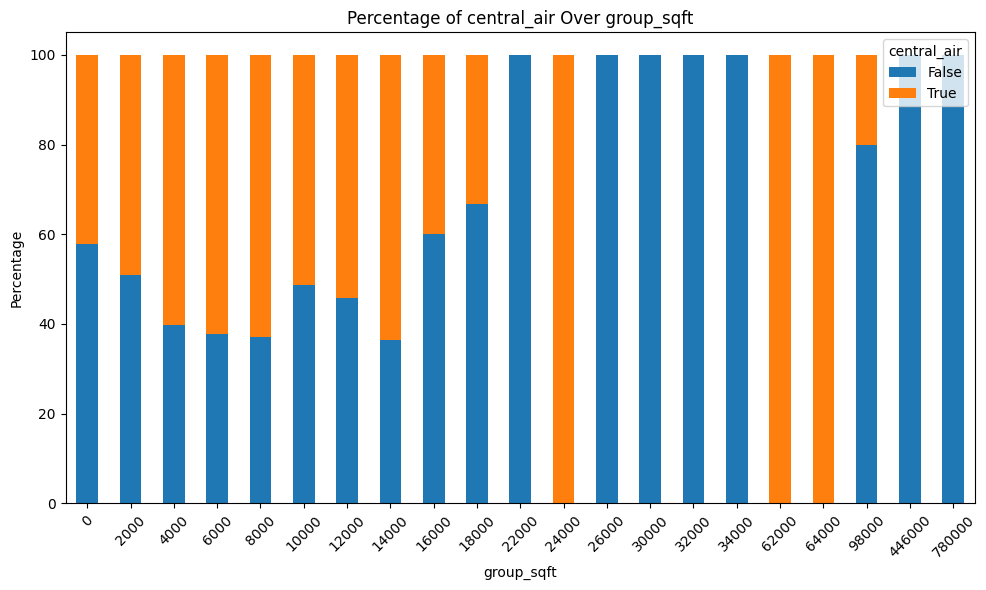

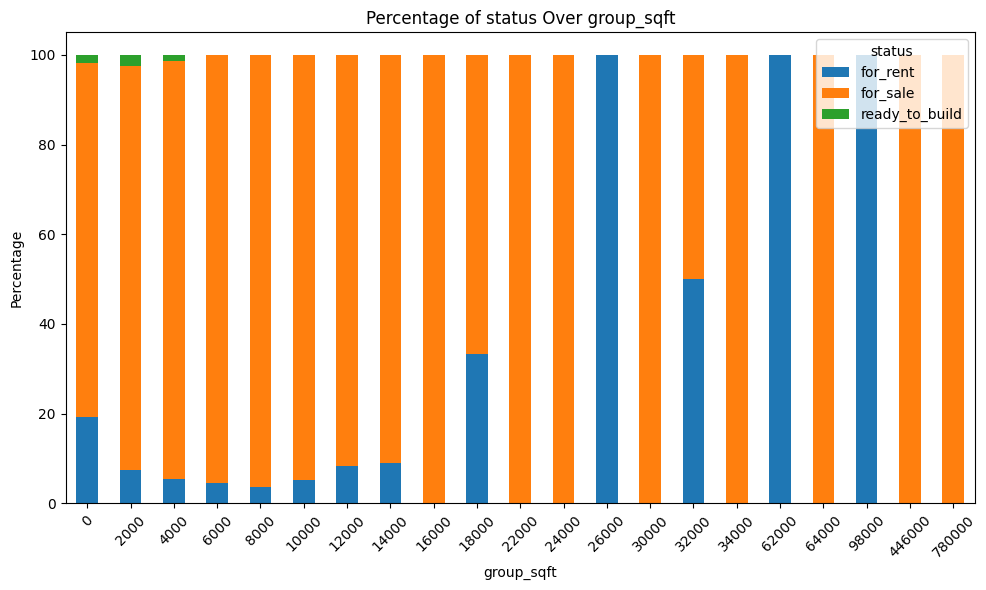

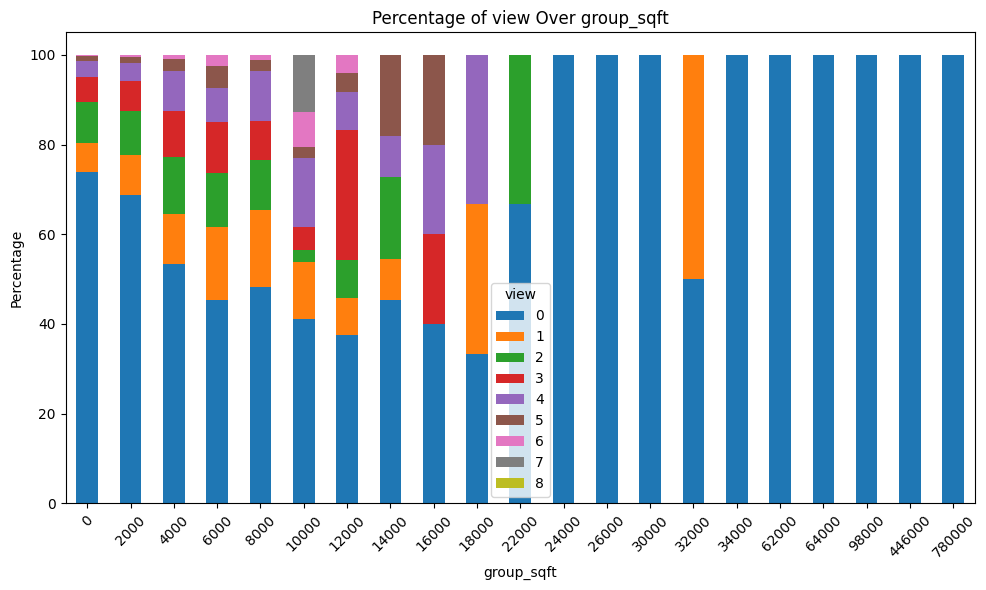

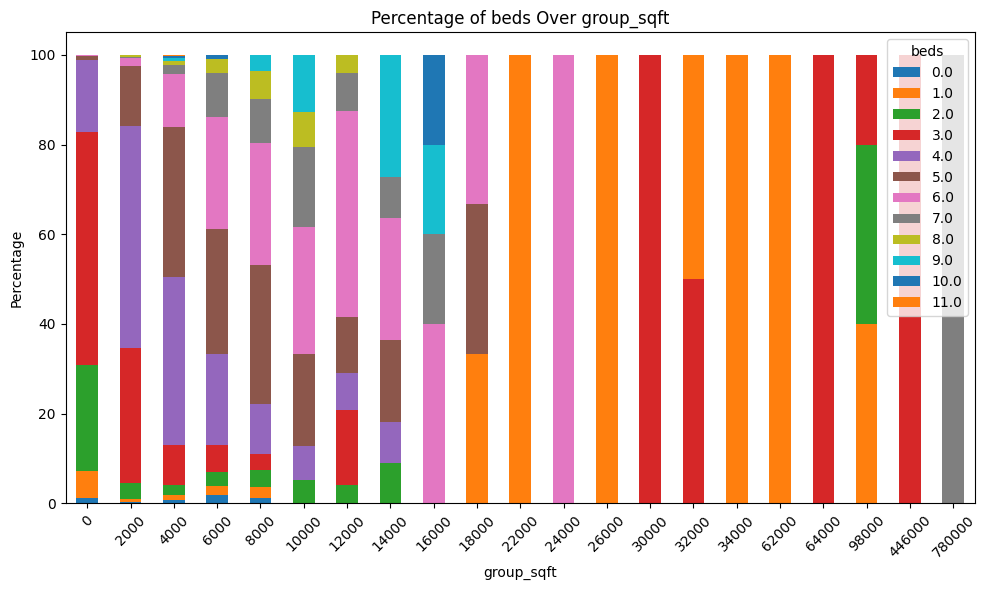

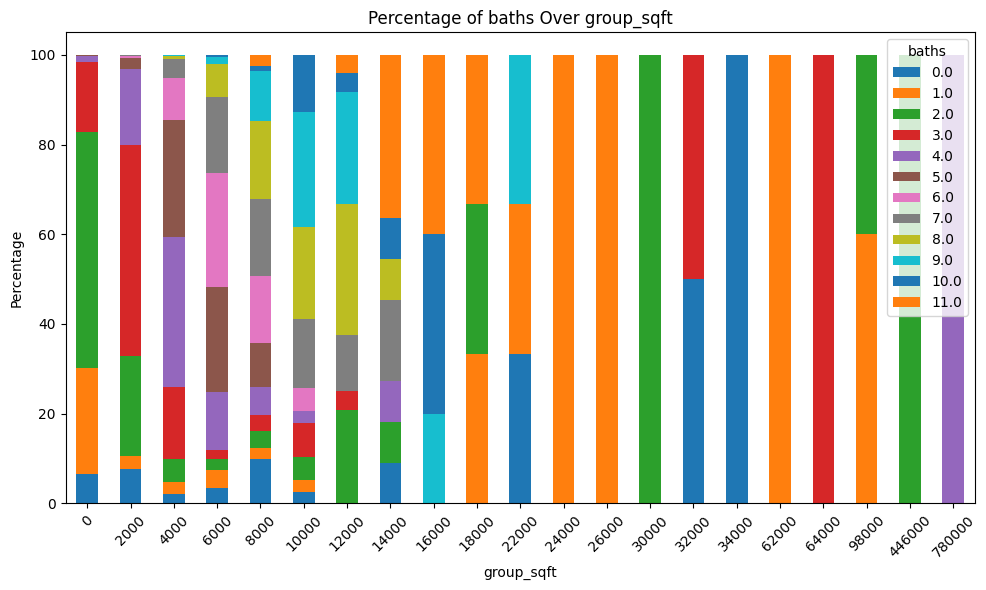

In [268]:
sqft_data = data.copy(deep=True)
sqft_data['group_sqft'] = data['sqft'].apply(group_by_sqft)
sqft_data = sqft_data[(sqft_data['beds'] < 12) & (sqft_data['baths'] < 12) & (sqft_data['baths'] < 12)]

for col in againstSqftCols:
    stacked_barplot(sqft_data, 'group_sqft', col)

## Correlations

In [269]:
toCorrCols = [
    'sqft',
    'year_built',
    'beds',
    'baths',
    'garage',
    'stories',
    'view',
    'kitchen_fac',
    'house_fac',
    'central_heat',
    'forced_air',
    'basement'
]

In [270]:
def get_numeric(data):
    le = LabelEncoder()
    numericData = pd.DataFrame(data.select_dtypes(include=['number']))
    # numericData['price'] = np.log(numericData['price']) 
    labels = dict()
    cat_cols = data.select_dtypes(include=['category', 'object']).columns
    for col in cat_cols:
        if col == 'status':
            continue
    le.fit(data[col])
    numericData[col] = le.transform(data[col])
    labels[col] = dict(zip(le.classes_, le.transform(le.classes_)))

    return numericData
    
def corr_heatmap(data, label=""):
    numeric_data = get_numeric(data)
    corr = numeric_data.corr()

    plt.figure(figsize=(20, 20))
    cmap = diverging_palette(220, 220, as_cmap=True)
    heatmap(corr, annot=True, fmt=".3f", cmap = cmap, linewidths=1, square=True, center=0, vmax=1, vmin=-1, cbar=False)
    plt.title(f'{label}')
    plt.show()

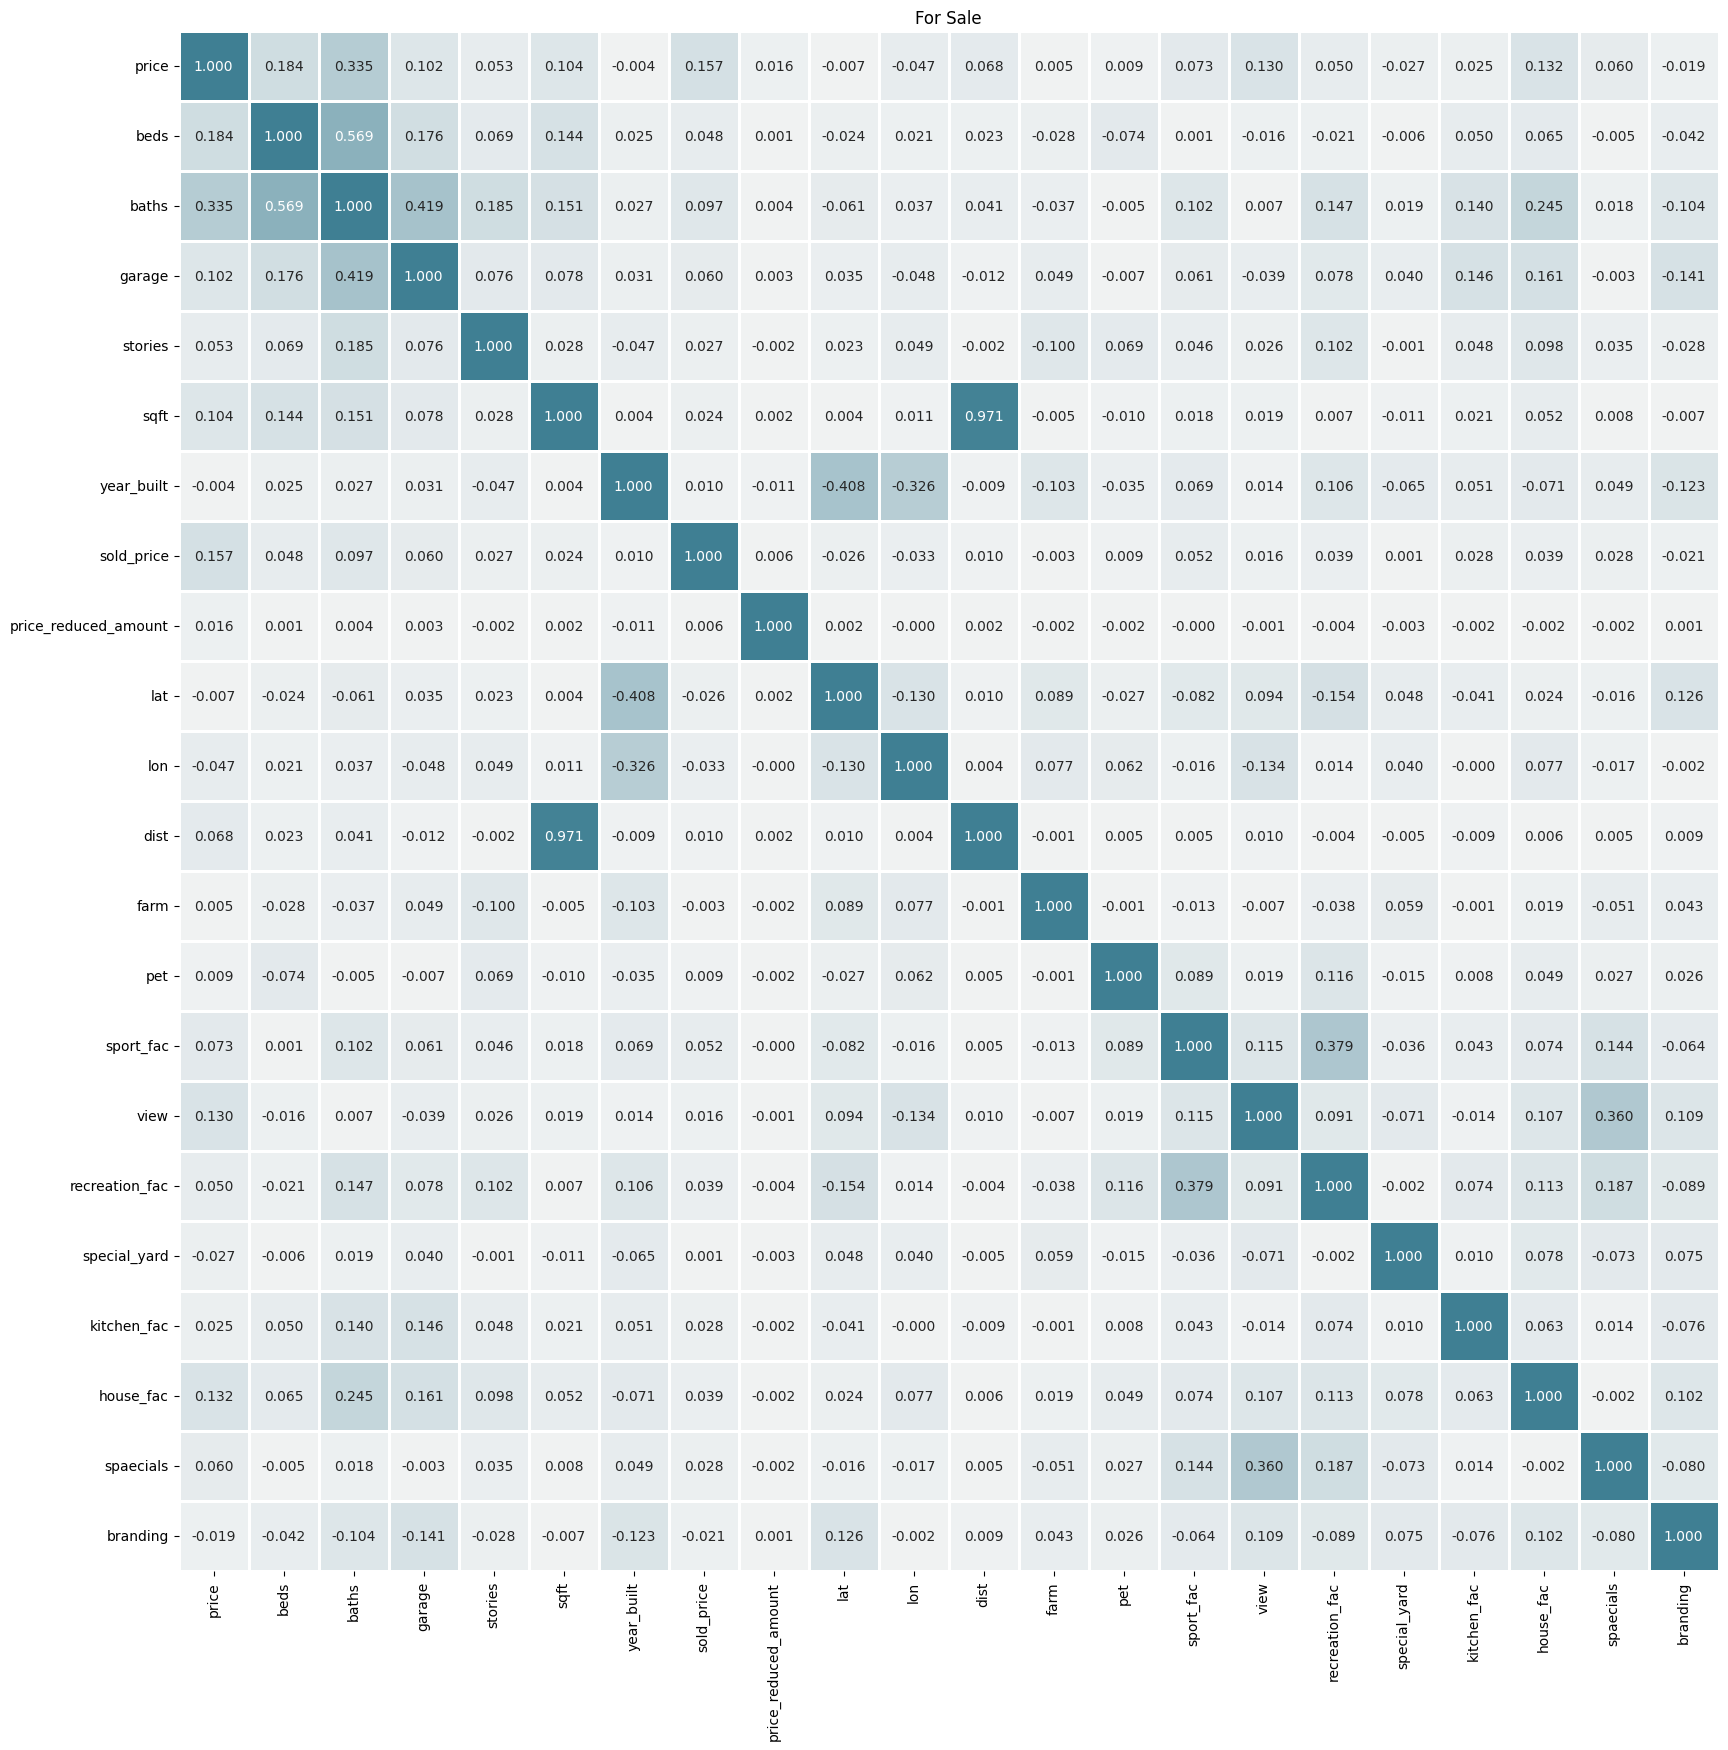

In [271]:
corr_heatmap(data[data['status'] == 'for_sale'], 'For Sale')

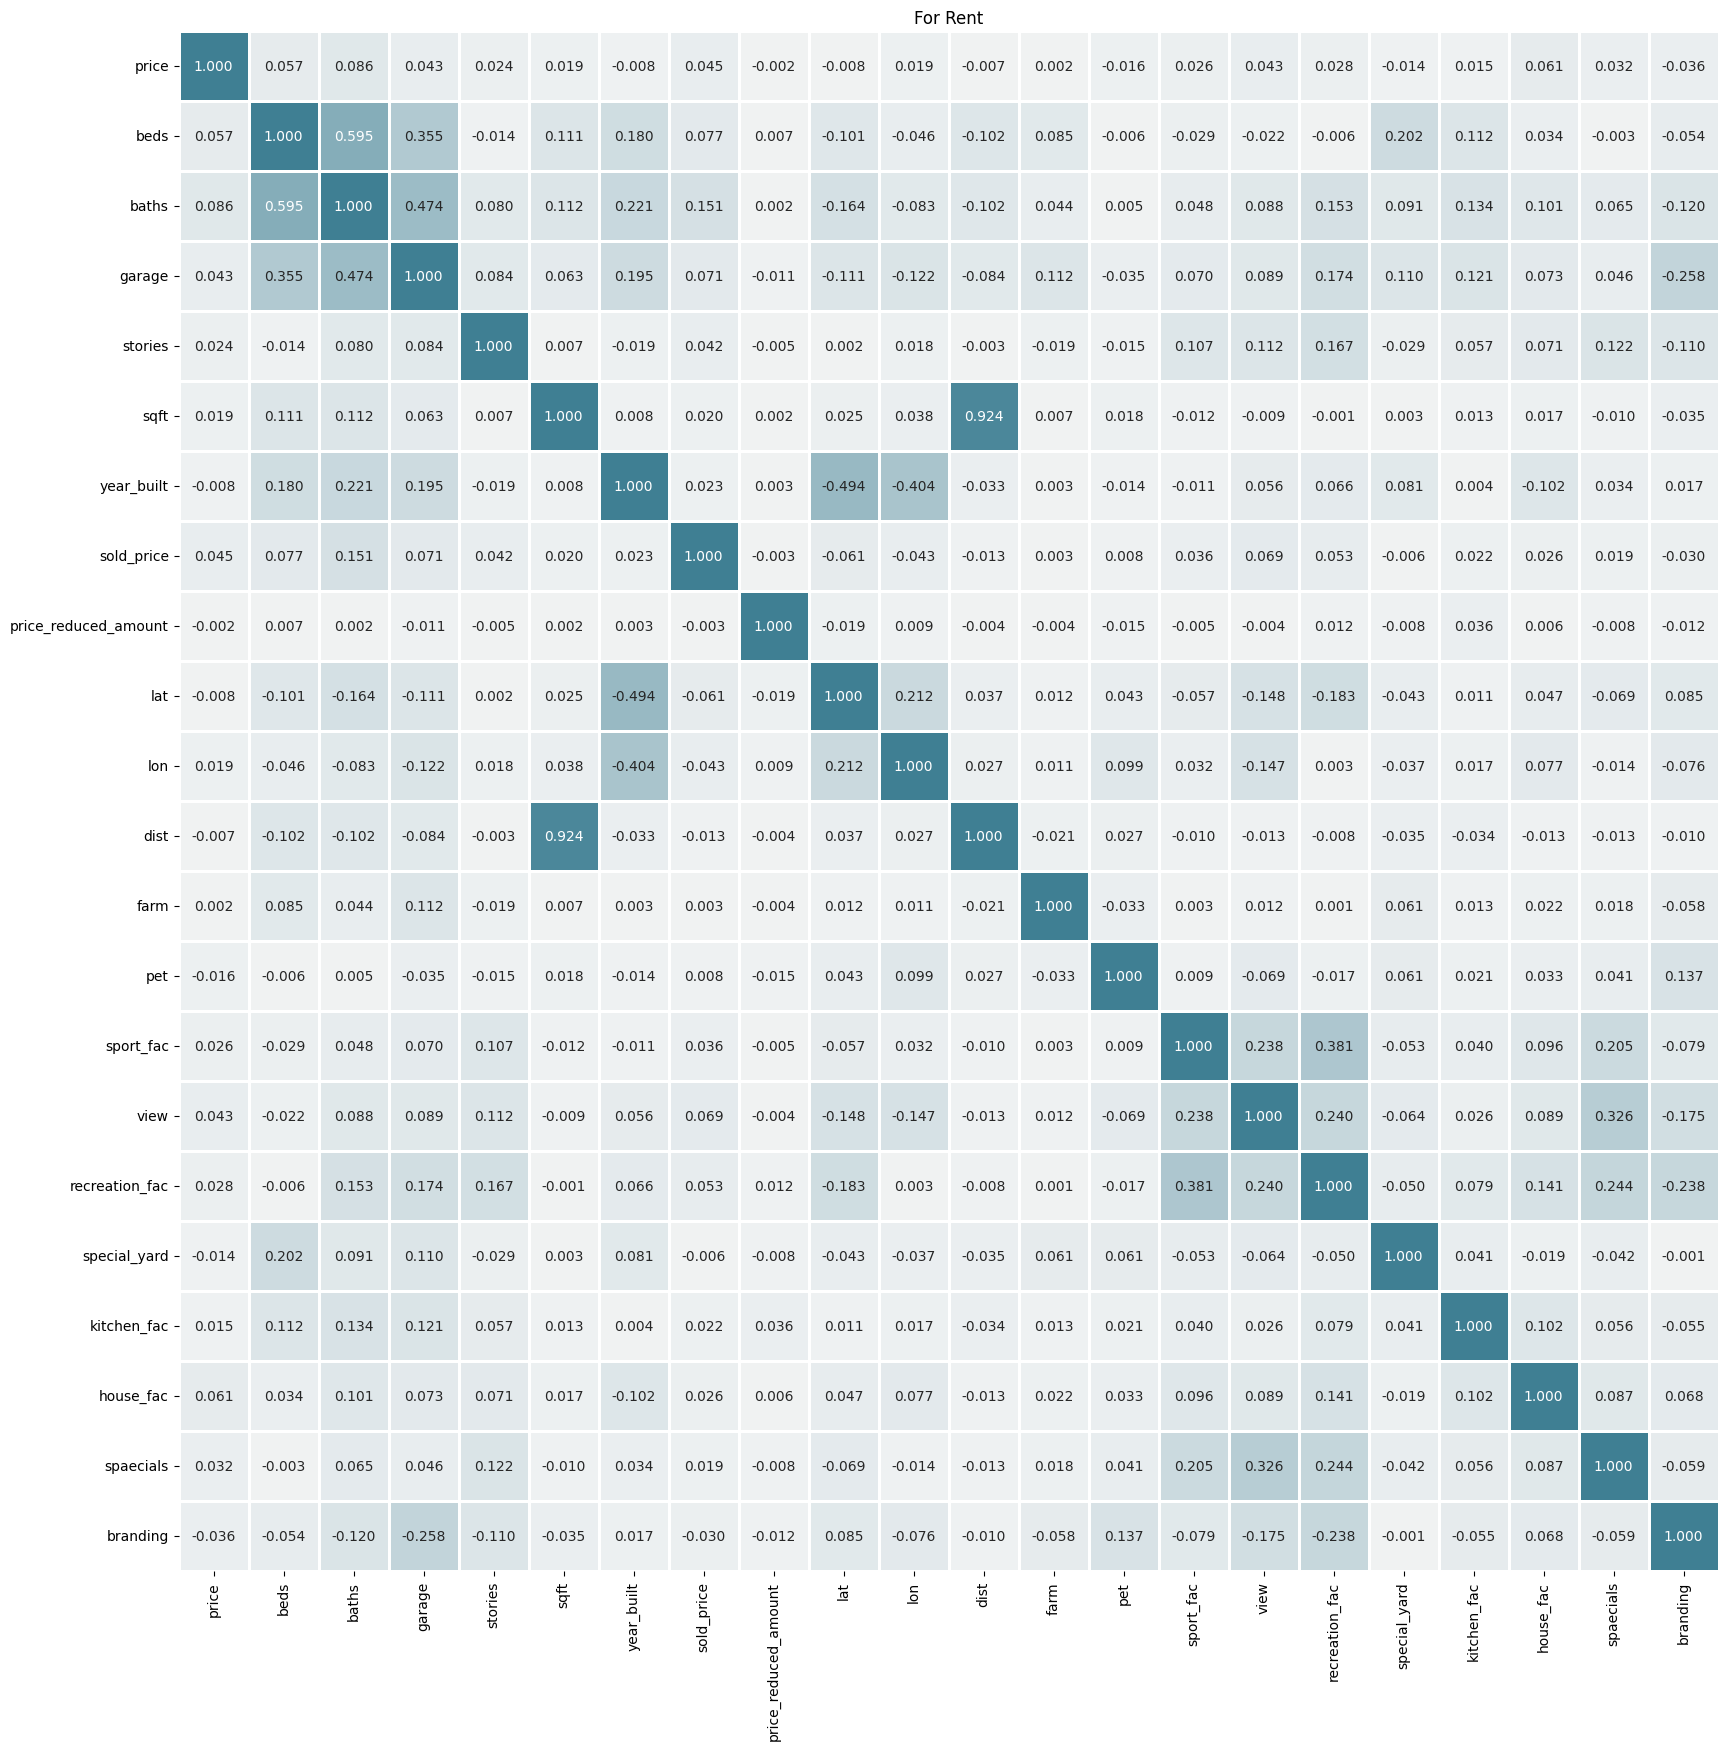

In [272]:
corr_heatmap(data[data['status'] == 'for_rent'], 'For Rent')


## Heatmaps

C:\Users\asus\AppData\Local\Temp\ipykernel_20440\3125631704.py:7: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


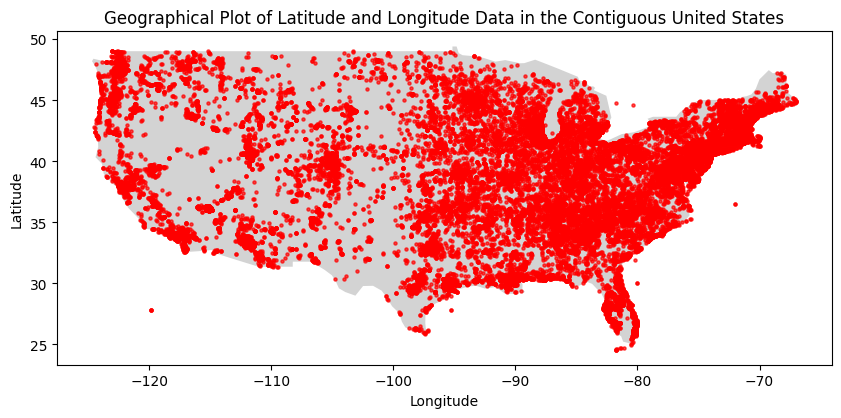

In [273]:
us_data = data[(data['lat'] >= 24.396308) & (data['lat'] <= 49.384358) & 
               (data['lon'] >= -125.0) & (data['lon'] <= -66.93457)]

geometry = [Point(xy) for xy in zip(us_data['lon'], us_data['lat'])]
gdf = gpd.GeoDataFrame(us_data, geometry=geometry)

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
us = world[world.name == "United States of America"]

contiguous_us_bbox = box(minx=-125.0, miny=24.396308, maxx=-66.93457, maxy=49.384358)

us_contiguous = us.geometry.intersection(contiguous_us_bbox)

fig, ax = plt.subplots(figsize=(10, 10))
us_contiguous.plot(ax=ax, color='lightgrey')
gdf.plot(ax=ax, color='red', markersize=5, alpha=0.7)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Geographical Plot of Latitude and Longitude Data in the Contiguous United States')
plt.show()


C:\Users\asus\AppData\Local\Temp\ipykernel_20440\1565598697.py:7: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


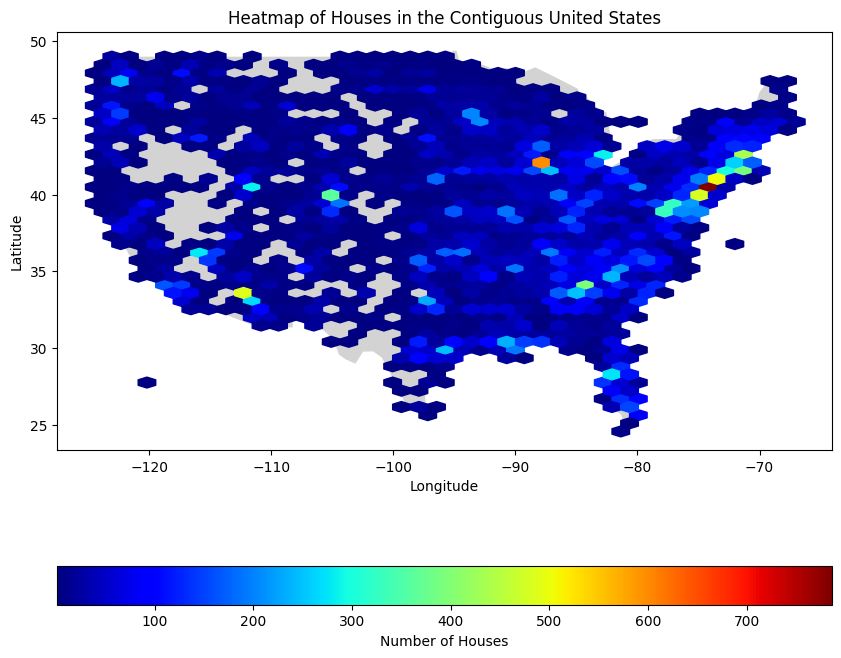

In [274]:


us_data = data[(data['lat'] >= 24.396308) & (data['lat'] <= 49.384358) & 
               (data['lon'] >= -125.0) & (data['lon'] <= -66.93457)]

geometry = [Point(xy) for xy in zip(us_data['lon'], us_data['lat'])]
gdf = gpd.GeoDataFrame(us_data, geometry=geometry)

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
us = world[world.name == "United States of America"]

contiguous_us_bbox = box(minx=-125.0, miny=24.396308, maxx=-66.93457, maxy=49.384358)

us_contiguous = us.geometry.intersection(contiguous_us_bbox)

fig, ax = plt.subplots(figsize=(10, 10))
us_contiguous.plot(ax=ax, color='lightgrey')

hb = ax.hexbin(gdf['lon'], gdf['lat'], gridsize=40, cmap='jet', mincnt=1)

cb = fig.colorbar(hb, ax=ax, orientation='horizontal')
cb.set_label('Number of Houses')

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Heatmap of Houses in the Contiguous United States')
plt.show()


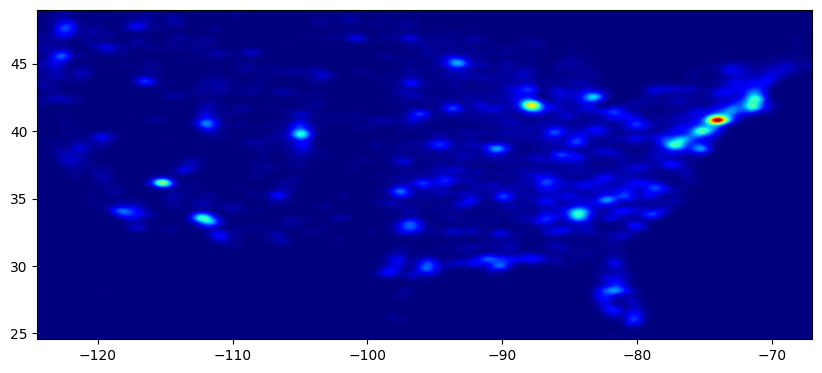

In [275]:
def heat(x, y, s, bins=1000):
    heatmap, xedges, yedges = np.histogram2d(x, y, bins=bins)
    heatmap = gaussian_filter(heatmap, sigma=s)

    extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
    return heatmap.T, extent

fig, ax = plt.subplots(figsize=(10, 10))
img, extent = heat(us_data['lon'], us_data['lat'], 8)
ax.imshow(img, extent=extent, origin='lower', cmap='jet')

plt.show()

# Group Members

* Matin Bazrafshan - 810100093
* Mohammad Reza Nemati - 810100226
* Parva Sharifi - 810100171
* Mohammad Farrahi - 810198451

